In [1]:
import ast
import math
from typing import List
import warnings
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import spacy

from modules.plotting_scripts import plot_surprisals, plot_all_in_one, get_avg_df, plot_freq_infreq_full, plot_avg_pos_neg

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

### Surprisals Analysis

In [8]:
wikitext_surprisals = '../results/lexique_results/shuffled_bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [9]:
surprisals = (surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

surprisals.insert(0, 'Token', surprisals.pop('Token'))
surprisals

/tmp/ipykernel_2804089/1593569163.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0),


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,MeanNegSurprisal,StdevNegSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
0,a,0,3931,14.229314,0.342920,14.313623,0.045051,0.000000,512,0.000000,0.000000
1,a,20000,0,1.648861,1.977923,13.486023,2.505406,0.652344,512,-12.580453,1.635002
2,a,40000,0,1.227708,1.852831,13.220064,2.546648,0.751953,512,-0.421153,-0.125091
3,a,60000,0,1.168194,1.748331,13.048685,5.394724,0.753906,512,-0.059514,-0.104500
4,a,80000,0,1.161881,1.885903,14.119462,1.728189,0.751953,512,-0.006312,0.137571
...,...,...,...,...,...,...,...,...,...,...,...
263257,zu,1600000,0,2.781132,3.277791,28.736006,NaN,0.500000,4,0.088701,0.182722
263258,zu,1700000,0,2.847625,3.296618,29.500854,NaN,0.500000,4,0.066493,0.018827
263259,zu,1800000,0,2.986012,3.461546,29.215361,NaN,0.500000,4,0.138387,0.164928
263260,zu,1900000,0,2.985151,3.501313,28.795647,NaN,0.500000,4,-0.000861,0.039767


In [11]:
surprisals['Token'].nunique()

9078

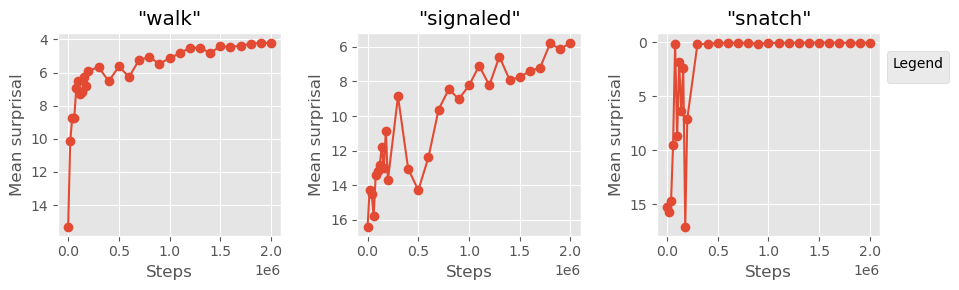

{}

In [12]:
random_1 = random.choice(surprisals['Token'].unique().tolist())
random_2 = random.choice(surprisals['Token'].unique().tolist())
plot_surprisals(['walk', 'signaled', 'snatch'], surprisals)   # good choices: 'ladder', 'composite', 'signaled', 'continual', 'depressed', 'snatch'

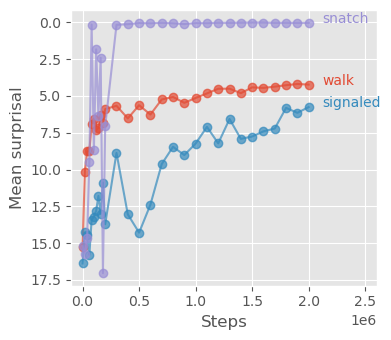

In [13]:
plot_all_in_one(['walk', 'signaled', 'snatch'], surprisals)

In [14]:
# Tokens that haven't converged
not_converged = surprisals.groupby('Token')\
                         .agg(first_surprisal=('MeanSurprisal', 'first'), 
                              last_surprisal=('MeanSurprisal', 'last'))\
                         .reset_index()\
                         .assign(overall_surprisal_diff=lambda x: x['last_surprisal'] - x['first_surprisal'])\
                         .query('overall_surprisal_diff >= 0')\
                         .reset_index(drop=True)
not_converged

,Token,first_surprisal,last_surprisal,overall_surprisal_diff
0,agenda,14.385452,14.530394,0.144941
1,arguably,15.969370,18.546284,2.576914
2,automobiles,13.881344,14.232363,0.351019
3,banging,15.381359,18.985399,3.604040
4,blended,14.523825,18.864544,4.340719
...,...,...,...,...
137,variable,15.045434,18.539169,3.493735
138,vera,14.920692,20.673443,5.752750
139,wharf,14.530179,18.905180,4.375001
140,wired,16.231590,22.428404,6.196814


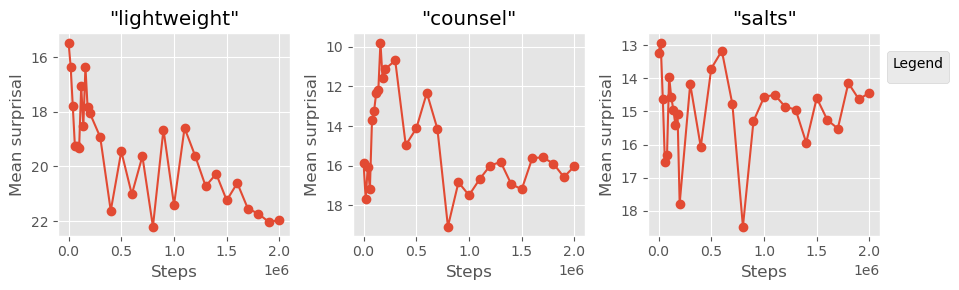

{}

In [15]:
samples = not_converged.Token.sample(3).tolist()    # 'runaway', 'lightweight'
plot_surprisals(samples, surprisals)

### Most vs least frequent words

Percentage of frequent words in the dataset (occuring at least 512 times): 0.26%
Percentage of infrequent words in the dataset (occuring only once): 26.46%


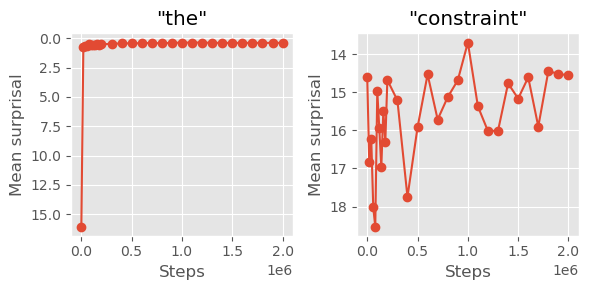

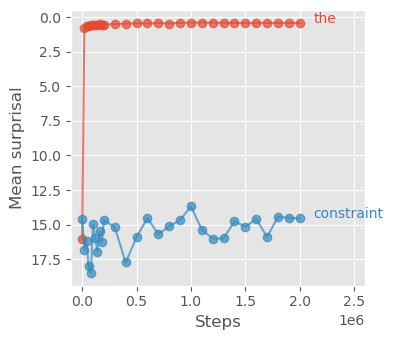

In [11]:
frequent = surprisals[surprisals['NumExamples'] == 512]
infrequent = surprisals[surprisals['NumExamples'] == 1]

print(f'Percentage of frequent words in the dataset (occuring at least 512 times): {len(frequent)/len(surprisals)*100:.2f}%')
print(f'Percentage of infrequent words in the dataset (occuring only once): {len(infrequent)/len(surprisals)*100:.2f}%')

sample_infreq = random.choice(infrequent['Token'].drop_duplicates().tolist())

# plot_surprisals(
#     frequent['Token'].drop_duplicates().sample(1).tolist() + infrequent['Token'].drop_duplicates().sample(1).tolist(), 
#     surprisals
#     )
plot_surprisals(
    ['the', 'constraint'], # good choices: 'immortal', 'challenging', 'constraint', 'exploring'
    surprisals
    )

plot_all_in_one(['the', 'constraint'], surprisals)

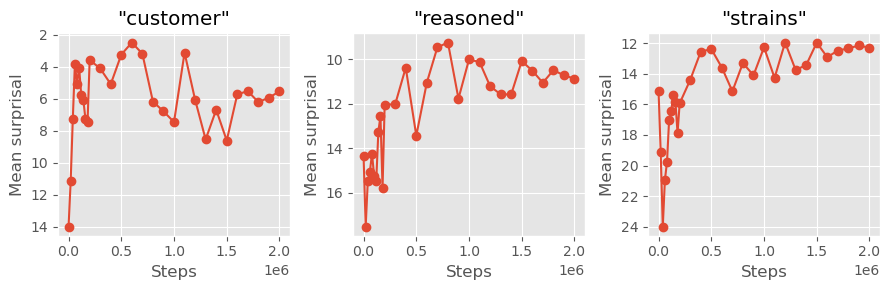

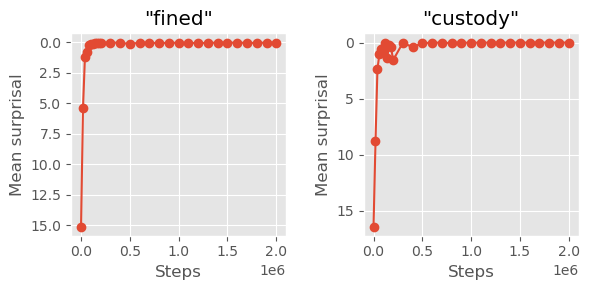

In [51]:
samples = infrequent.Token.sample(3)
plot_surprisals(samples, surprisals)
plot_surprisals(['fined', 'custody'], surprisals)

Text(0, 0.5, 'Mean Surprisal')

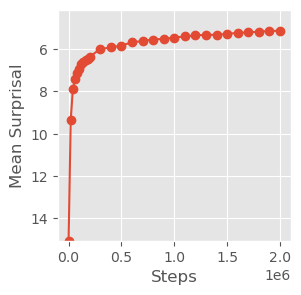

In [14]:
# for each step, average surprisal across all words
avg_surprisals = get_avg_df([surprisals])[0]

plt.figure(figsize=(3, 3))
plt.plot(avg_surprisals.Steps, avg_surprisals.MeanSurprisal, marker='o')
plt.ylim(avg_surprisals.MeanSurprisal.max(), avg_surprisals.MeanSurprisal.min()-1)
plt.xlabel('Steps')
plt.ylabel('Mean Surprisal')

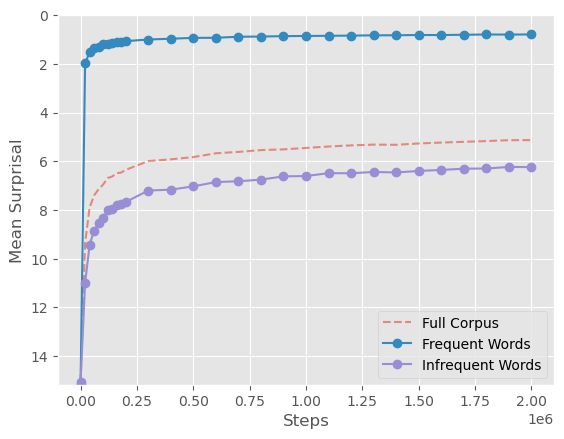

In [15]:
# for each step: 
# avg_freq_surprisals: average surprisal across all words with at least 512 examples (frequent words)
# avg_infreq_surprisals: average surprisal across all words with only 1 example (infrequent words)
# avg_surprisals: average surprisal across all words
avg_freq_surprisals, avg_infreq_surprisals, avg_surprisals = get_avg_df([frequent, infrequent, surprisals])

plt.figure()

plt.plot(avg_surprisals.Steps, avg_surprisals.MeanSurprisal, linestyle='--', alpha=0.6, label='Full Corpus')
plt.plot(avg_freq_surprisals.Steps, avg_freq_surprisals.MeanSurprisal, marker='o', label='Frequent Words')
plt.plot(avg_infreq_surprisals.Steps, avg_infreq_surprisals.MeanSurprisal, marker='o', label='Infrequent Words')

plt.ylim(max(avg_freq_surprisals.MeanSurprisal.max(), avg_infreq_surprisals.MeanSurprisal.max()), 0)
plt.xlabel('Steps')
plt.ylabel('Mean Surprisal')
plt.legend()
plt.show()

In [16]:
data = {
    'Category': ['Frequent words', 'Infrequent words', 'Full corpus'],
    'Min Surprisal': [round(avg_freq_surprisals.MeanSurprisal.min(), 2), round(avg_infreq_surprisals.MeanSurprisal.min(), 2), round(avg_surprisals.MeanSurprisal.min(), 2)],
    'Max Surprisal': [round(avg_freq_surprisals.MeanSurprisal.iloc[1:].max(), 2), round(avg_infreq_surprisals.MeanSurprisal.iloc[1:].max(), 2), round(avg_surprisals.MeanSurprisal.iloc[1:].max(), 2)],
    'Average Variability': [round(avg_freq_surprisals.Diffs.iloc[2:].mean(), 2), round(avg_infreq_surprisals.Diffs.iloc[2:].mean(), 2), round(avg_surprisals.Diffs.iloc[2:].mean(), 2)]
}

pd.DataFrame(data)


,Category,Min Surprisal,Max Surprisal,Average Variability
0,Frequent words,0.79,1.99,-0.04
1,Infrequent words,6.23,11.00,-0.18
2,Full corpus,5.13,9.36,-0.16


### Words with different POS

In [17]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text.lower() in pos_dict and not token.pos_ in pos_dict[token.text.lower()]:
                pos_dict[token.text.lower()].append(token.pos_)
            else:
                pos_dict[token.text.lower()] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['Token', 'POS'])

In [18]:
def plot_pos_avg(dfs: List[pd.DataFrame]):
    plt.style.use('ggplot')
    plt.figure()
    max_y = 0
    min_y = float('inf')
    for df in dfs:
        avg = (df.groupby('Steps')
                 .agg({'MeanSurprisal': 'mean', 'POS': 'first'})
                 .reset_index()
                 .assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0)))

        plt.plot(avg['Steps'], avg['MeanSurprisal'], label=f"{avg['POS'].values[0][0]}")
        max_y = avg['MeanSurprisal'].max() if avg['MeanSurprisal'].max() > max_y else max_y
        min_y = avg['MeanSurprisal'].min() if avg['MeanSurprisal'].min() < min_y else min_y

    plt.ylim(max_y, min_y - 1)
    plt.xlabel('Steps')
    plt.ylabel('Mean Surprisal')
    # plt.xscale('log')
    plt.legend()
    plt.show()

In [19]:
def plot_all_in_one(words:List[str], surprisals_df):
    plt.style.use('ggplot')
    
    # Create a new figure with a specific size (width=10, height=6)
    plt.figure(figsize=(4, 3.5))

    max_x = 0
    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word]
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        # Plot the data
        line, = plt.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o', alpha=0.7)

        # Annotate the end of the line
        x = word_data['Steps'].iloc[-1]
        y = word_data['MeanSurprisal'].iloc[-1]
        plt.annotate(word, (x, y), textcoords="offset points", xytext=(+10,+0), color=line.get_color())
        
        max_x = max(max_x, x)

    xlim = plt.gca().get_xlim()
    plt.gca().set_xlim(xlim[0], max_x * 1.3)  # increase the maximum x value by 30%
    
    # plt.title('All Words')
    plt.xlabel('Steps')
    plt.ylabel('Mean surprisal')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.tight_layout()
    plt.show()


In [ ]:
document = "../data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

In [ ]:
merged_df = pd.merge(surprisals, pos_tags, on='Token', how='inner')
merged_df.to_csv('../results/lexique_results/wikitext_surprisals_diffs_pos.csv', sep='\t', index=False)

In [ ]:
surps_with_pos = pd.read_csv('../results/lexique_results/wikitext_surprisals_diffs_pos.csv', sep='\t')
surps_with_pos['POS'] = surps_with_pos['POS'].apply(ast.literal_eval)
surps_with_pos

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
0,100th,0,3762,14.619419,0.510996,0.0,2,0.000000,0.000000,[ADJ]
1,100th,20000,10,7.110159,0.964662,0.0,2,-7.509260,0.453667,[ADJ]
2,100th,40000,10,8.165643,1.590769,0.0,2,1.055483,0.626106,[ADJ]
3,100th,60000,7,7.027547,1.110843,0.0,2,-1.138095,-0.479925,[ADJ]
4,100th,80000,1,4.709196,2.413492,0.0,2,-2.318352,1.302649,[ADJ]
...,...,...,...,...,...,...,...,...,...,...
264794,zu,1600000,0,2.781154,3.277767,0.5,4,0.088716,0.182716,[NOUN]
264795,zu,1700000,0,2.847632,3.296625,0.5,4,0.066478,0.018858,[NOUN]
264796,zu,1800000,0,2.986036,3.461543,0.5,4,0.138404,0.164918,[NOUN]
264797,zu,1900000,0,2.985156,3.501315,0.5,4,-0.000880,0.039771,[NOUN]


In [ ]:
num_nouns = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'NOUN' in pos_list)]['Token'].nunique()
num_verbs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'VERB' in pos_list)]['Token'].nunique()
num_adjs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADJ' in pos_list)]['Token'].nunique()
num_advs = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADV' in pos_list)]['Token'].nunique()

# Distribution of lexical categories within the dataset
pd.DataFrame({
    'Categories': ['NOUN', 'VERB', 'ADJ', 'ADV'],
    'Frequency': [num_nouns, num_verbs, num_adjs, num_advs]   # CIC: Count in Corpus
})

,Categories,Frequency
0,NOUN,4680
1,VERB,2713
2,ADJ,1426
3,ADV,405


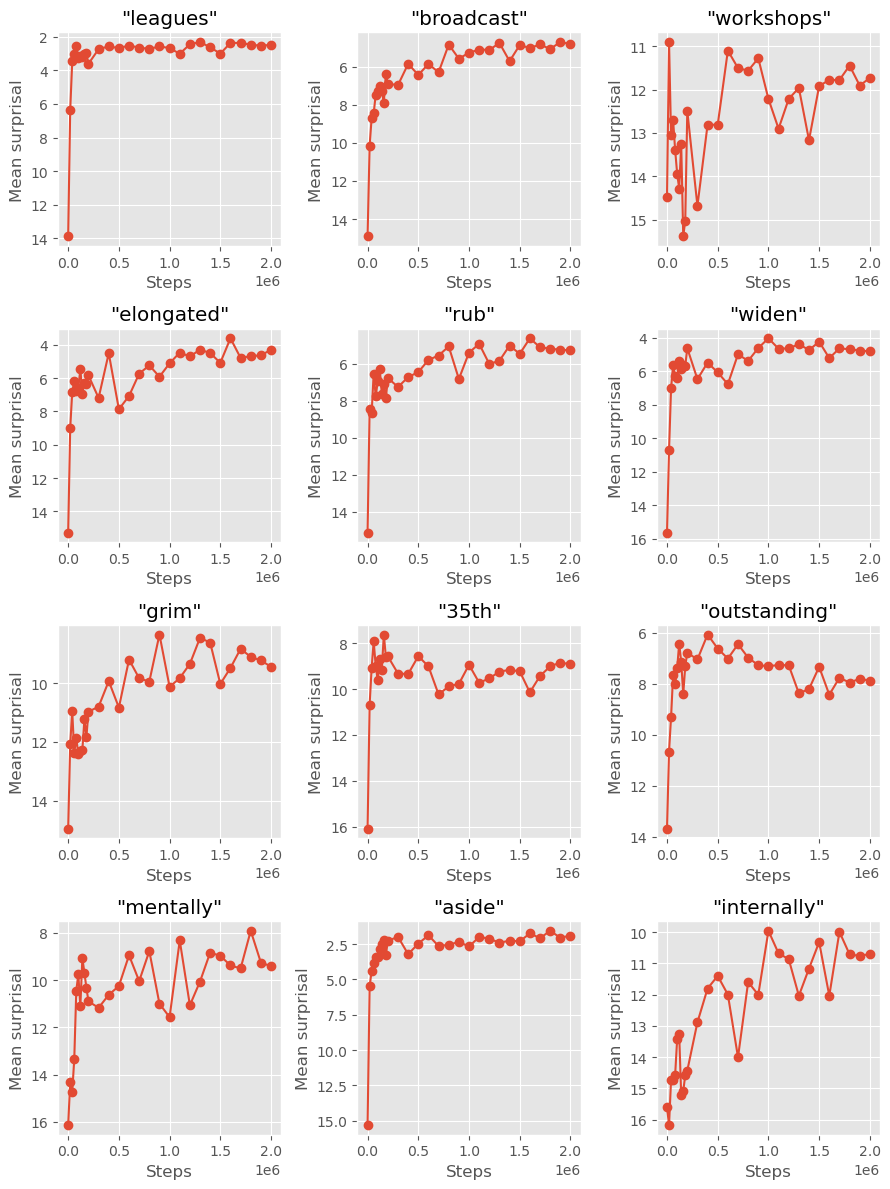

In [ ]:
noun = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'NOUN' in pos_list and len(pos_list) == 1)]
verb = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'VERB' in pos_list and len(pos_list) == 1)]
adj = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADJ' in pos_list and len(pos_list) == 1)]
adv = surps_with_pos[surps_with_pos['POS'].apply(lambda pos_list: 'ADV' in pos_list and len(pos_list) == 1)]

noun_sample = noun['Token'].drop_duplicates().sample(3).tolist()
verb_sample = verb['Token'].drop_duplicates().sample(3).tolist()
adj_sample = adj['Token'].drop_duplicates().sample(3).tolist()
adv_sample = adv['Token'].drop_duplicates().sample(3).tolist()

plot_surprisals(
    noun_sample + verb_sample + adj_sample + adv_sample, 
    surps_with_pos
    )

**Learning Curves for Frequent vs. Infrequent Words in the Same Lexical Class.**

*Note: the ‘frequent word’ in this analysis is the one with the highest number of occurrences.*

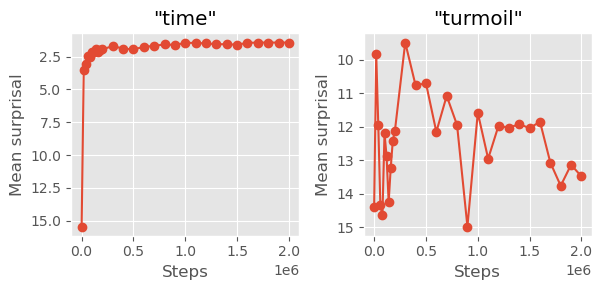

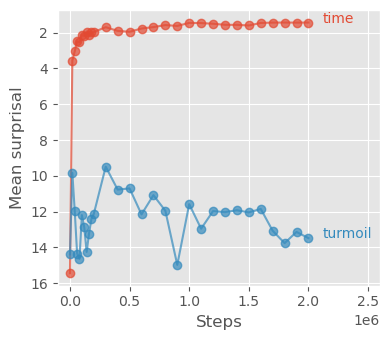

In [ ]:
# Nouns
frequent_noun = noun.loc[noun.NumExamples.idxmax(), 'Token']    # 231 examples
infrequent_noun = noun.loc[noun.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist() # 'clerk' / 'weights' / 'turmoil'

# plot_surprisals([frequent_noun, 'weights'], surps_with_pos)
plot_surprisals([frequent_noun, 'turmoil'], surps_with_pos)
plot_all_in_one([frequent_noun, 'turmoil'], surps_with_pos)

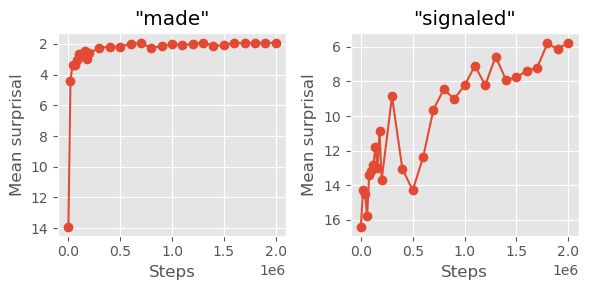

In [ ]:
# Verbs
frequent_verb = verb.loc[verb.NumExamples.idxmax(), 'Token']    # 165 examples
infrequent_verb = verb.loc[verb.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist() # 'explored', 'signaled'

plot_surprisals([frequent_verb] + ['signaled'], surps_with_pos)

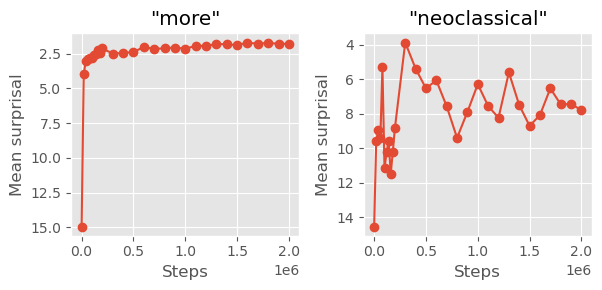

In [ ]:
# Adjectives
frequent_adj = adj.loc[adj.NumExamples.idxmax(), 'Token']    # 203 examples
infrequent_adj = adj.loc[adj.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist()

plot_surprisals([frequent_adj] + infrequent_adj, surps_with_pos)

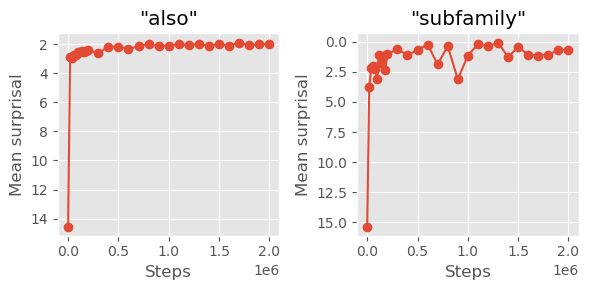

In [ ]:
# Adverbs
frequent_adv = adv.loc[adv.NumExamples.idxmax(), 'Token']    # 343 examples
infrequent_adv = adv.loc[adv.Token.isin(infrequent.Token), 'Token'].drop_duplicates().sample(1).tolist()

plot_surprisals([frequent_adv] + infrequent_adv, surps_with_pos)

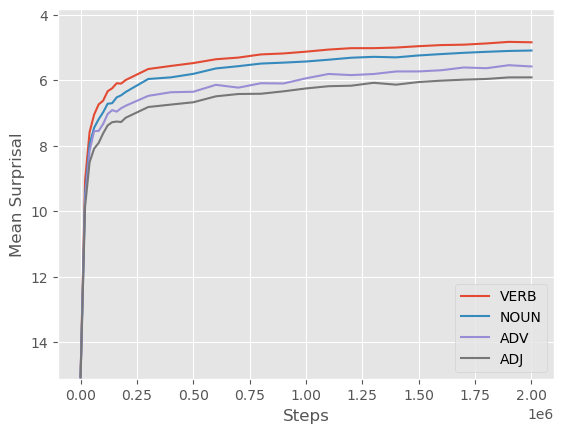

In [ ]:
plot_pos_avg([verb, noun, adv, adj])

In [ ]:
avg_verb, avg_noun, avg_adv, avg_adj = get_avg_df([verb, noun, adv, adj])

pos_data = {
    'Category': ['VERB', 'NOUN', 'ADV', 'ADJ'],
    'Min Surprisal': [round(avg_verb.MeanSurprisal.min(), 2), round(avg_noun.MeanSurprisal.min(), 2), round(avg_adv.MeanSurprisal.min(), 2), round(avg_adj.MeanSurprisal.min(), 2)],
    'Max Surprisal': [round(avg_verb.MeanSurprisal.iloc[1:].max(), 2), round(avg_noun.MeanSurprisal.iloc[1:].max(), 2), round(avg_adv.MeanSurprisal.iloc[1:].max(), 2), round(avg_adj.MeanSurprisal.iloc[1:].max(), 2)],
    'Average Variability': [round(avg_verb.Diffs.iloc[2:].mean(), 2), round(avg_noun.Diffs.iloc[2:].mean(), 2), round(avg_adv.Diffs.iloc[2:].mean(), 2), round(avg_adj.Diffs.iloc[2:].mean(), 2)]
}

pd.DataFrame(pos_data)

,Category,Min Surprisal,Max Surprisal,Average Variability
0,VERB,4.83,9.08,-0.16
1,NOUN,5.10,9.48,-0.16
2,ADV,5.55,9.62,-0.15
3,ADJ,5.92,9.86,-0.15


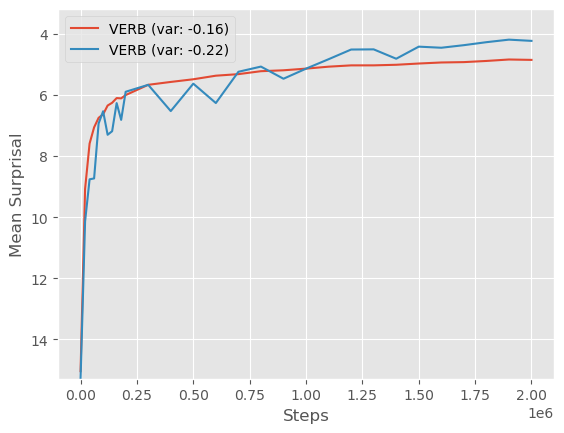

In [ ]:
plot_pos_avg([verb, verb[verb['Token'] == 'walk']])

### Checking that the words aren't used in the wrong context

#### Method 1:

In [23]:
wikitext_surprisals = '../results/lexique_results/bert_surprisals.txt'
surprisals_m2 = pd.read_csv(wikitext_surprisals, delimiter='\t')
surprisals_m2

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,MeanNegSurprisal,StdevNegSurprisal,Accuracy,NumExamples
0,0,a,3931,14.229314,0.342920,14.222576,0.340467,0.00,512
1,0,aa,24157,15.597247,0.395568,15.635065,0.377204,0.00,16
2,0,abandon,19282,15.298998,NaN,15.329558,NaN,0.00,1
3,0,abandoned,10602,14.781739,0.365917,14.645662,0.343229,0.00,26
4,0,abandoning,6668,14.522403,NaN,14.542767,NaN,0.00,1
...,...,...,...,...,...,...,...,...,...
263257,2000000,zone,2,4.606952,3.610021,20.482609,5.235615,0.25,20
263258,2000000,zones,0,2.175875,2.910474,22.607683,7.924803,0.60,5
263259,2000000,zoo,5,5.894639,0.417886,12.460294,6.401729,0.00,2
263260,2000000,zoom,0,2.738938,1.513666,24.773903,3.427345,0.50,2


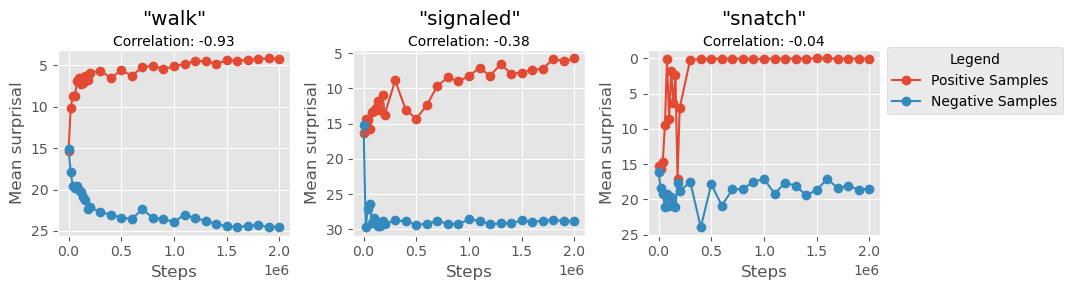

{'walk': -0.9335280848041597,
 'signaled': -0.38422918230851694,
 'snatch': -0.040454415888598536}

In [37]:
plot_surprisals(['walk', 'signaled', 'snatch'], surprisals_m2, neg_samples=True)

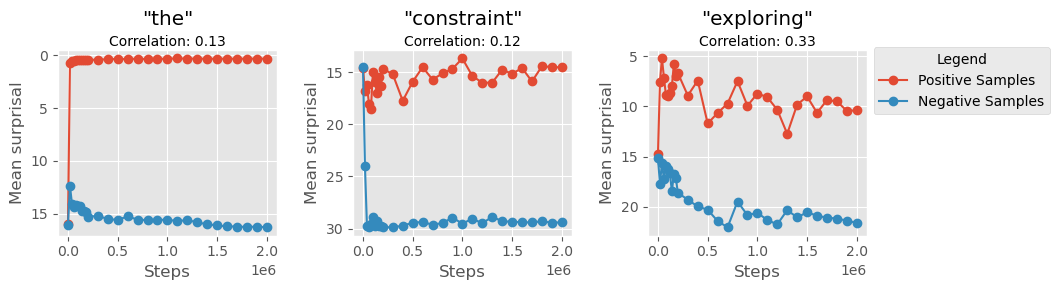

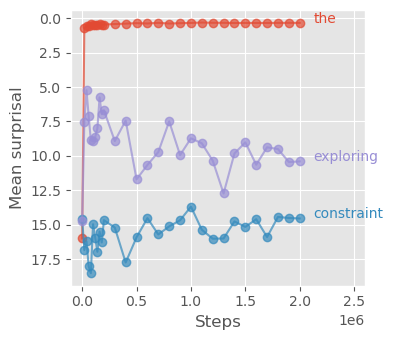

In [38]:
plot_surprisals(
    ['the', 'constraint', 'exploring'], # good choices: 'immortal', 'challenging', 'constraint', 'exploring'
    surprisals_m2,
    neg_samples=True
    )

plot_all_in_one(['the', 'constraint', 'exploring'], surprisals_m2)

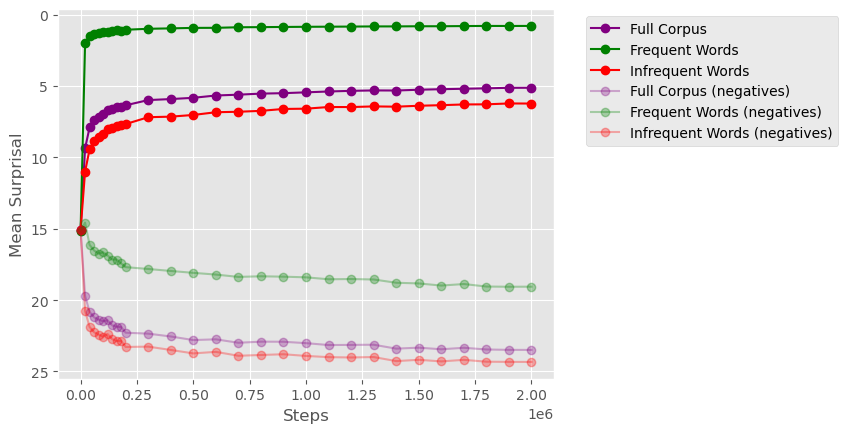

In [41]:
frequent = surprisals_m2[surprisals_m2['NumExamples'] == 512]
infrequent = surprisals_m2[surprisals_m2['NumExamples'] == 1]

positives = get_avg_df([surprisals_m2, frequent, infrequent], column='MeanSurprisal')
negatives = get_avg_df([surprisals_m2, frequent, infrequent], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives)


#### Method 2:

In [5]:
shuffled_path = '../results/lexique_results/shuffled_bert_surprisals.txt'
shuffled_surprisals = pd.read_csv(shuffled_path, delimiter='\t')
shuffled_surprisals

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,MeanNegSurprisal,StdevNegSurprisal,Accuracy,NumExamples
0,0,a,3931,14.229314,0.342920,14.313623,0.045051,0.00,512
1,0,aa,24157,15.597247,0.395568,15.358511,0.268017,0.00,16
2,0,abandon,19282,15.298998,NaN,15.450489,0.273718,0.00,1
3,0,abandoned,10602,14.781739,0.365917,14.826208,0.293622,0.00,26
4,0,abandoning,6668,14.522403,NaN,14.458101,0.296419,0.00,1
...,...,...,...,...,...,...,...,...,...
263257,2000000,zone,2,4.606952,3.610021,24.047709,4.278127,0.25,20
263258,2000000,zones,0,2.175875,2.910474,27.484955,2.906198,0.60,5
263259,2000000,zoo,5,5.894639,0.417886,19.335026,NaN,0.00,2
263260,2000000,zoom,0,2.738938,1.513666,27.484356,3.687961,0.50,2


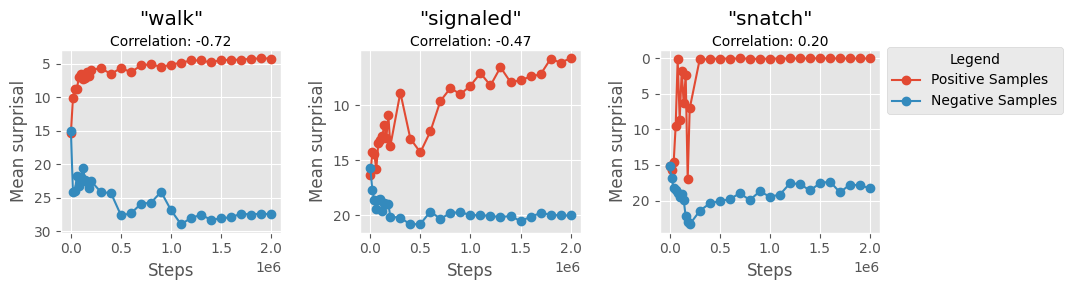

{'walk': -0.7172246057475519,
 'signaled': -0.4710530239920761,
 'snatch': 0.20323511146991816}

In [6]:
plot_surprisals(['walk', 'signaled', 'snatch'], shuffled_surprisals, neg_samples=True, first_step=False)

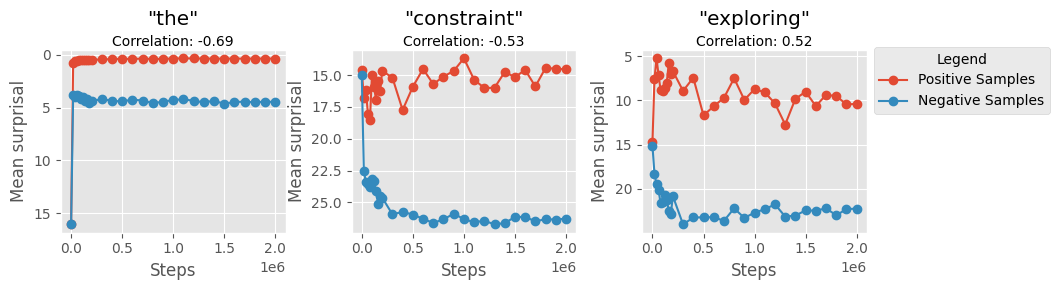

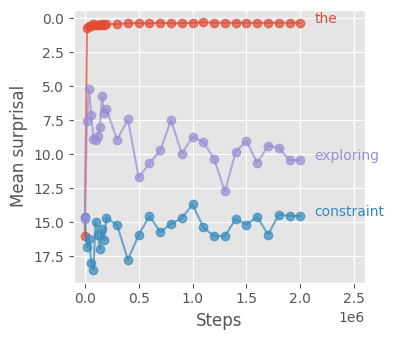

In [9]:
plot_surprisals(
    ['the', 'constraint', 'exploring'], # good choices: 'immortal', 'challenging', 'constraint', 'exploring'
    shuffled_surprisals,
    neg_samples=True, 
    first_step=False
    )

plot_all_in_one(['the', 'constraint', 'exploring'], shuffled_surprisals)

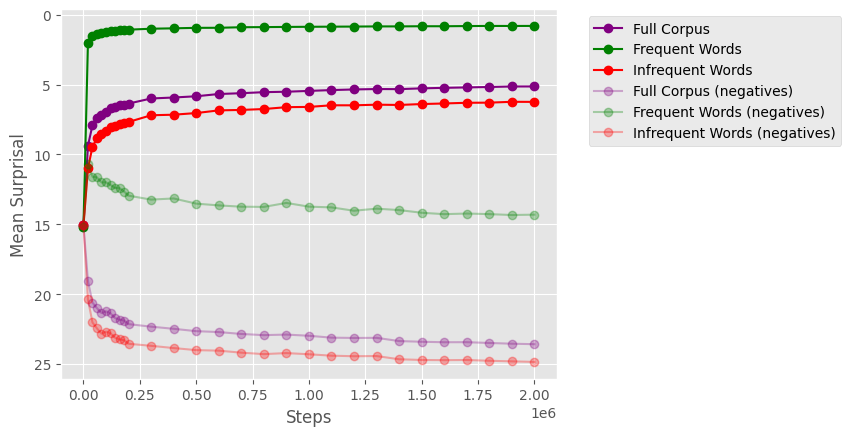

In [10]:
shuffled_frequent = shuffled_surprisals[shuffled_surprisals['NumExamples'] == 512]
shuffled_infrequent = shuffled_surprisals[shuffled_surprisals['NumExamples'] == 1]

positives = get_avg_df([shuffled_surprisals, shuffled_frequent, shuffled_infrequent], column='MeanSurprisal')
negatives = get_avg_df([shuffled_surprisals, shuffled_frequent, shuffled_infrequent], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives)

#### Toy

In [3]:
sample10_path = '../results/lexique_results/sample10_surprisals.txt'
sample10_surprisals = pd.read_csv(sample10_path, delimiter='\t')
sample10_surprisals

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,MeanNegSurprisal,StdevNegSurprisal,Accuracy,NumExamples
0,0,a,3890,14.213918,0.346971,14.195665,0.361547,0.000000,512
1,0,by,27737,16.030943,0.439596,16.029408,0.433057,0.000000,512
2,0,constraint,7480,14.581973,NaN,15.168314,NaN,0.000000,1
3,0,exploring,9474,14.721373,NaN,15.508900,NaN,0.000000,1
4,0,fined,15770,15.096849,NaN,14.677059,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...
285,2000000,of,0,0.334707,1.122243,18.036840,5.301032,0.943359,512
286,2000000,sob,3805,18.751545,NaN,24.932291,NaN,0.000000,1
287,2000000,the,0,0.329209,0.781387,16.573214,6.084897,0.945312,512
288,2000000,variable,8835,18.539169,NaN,21.833714,NaN,0.000000,1


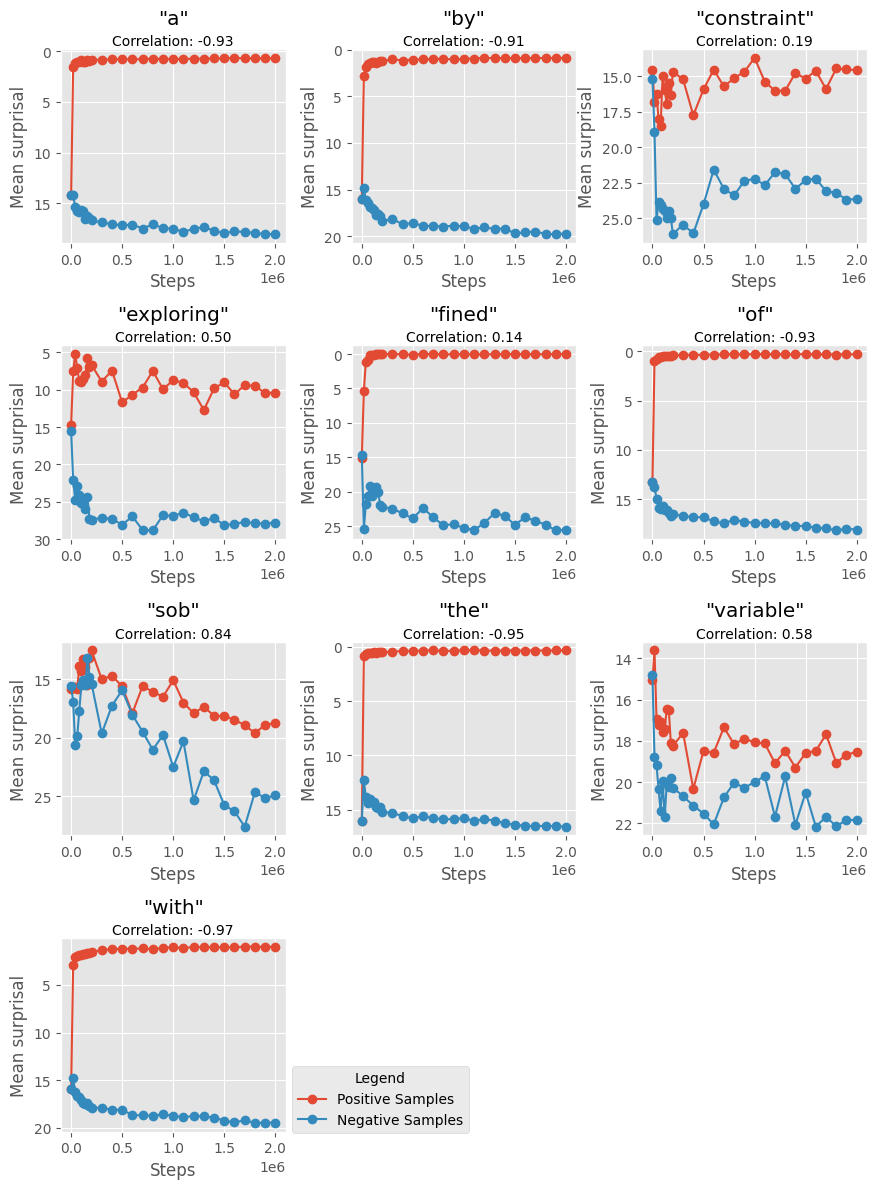

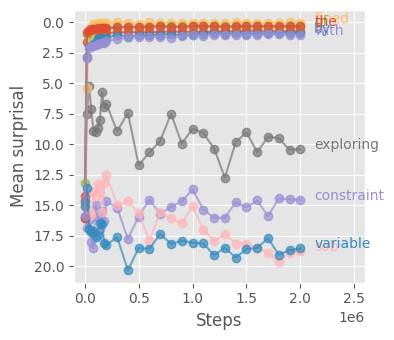

In [4]:
plot_surprisals(sample10_surprisals.Token.unique(), sample10_surprisals, neg_samples=True, first_step=False)
plot_all_in_one(sample10_surprisals.Token.unique(), sample10_surprisals)

In [59]:
sample40_indiv_path = '../results/lexique_results/sample40_IndivSurprisals.tsv'
sample40_indiv_surprisals = pd.read_csv(sample40_indiv_path, delimiter='\t')
sample40_indiv_surprisals

,Steps,Token,Surprisal,NegSurprisal,Example_num
0,0,absorption,14.396362,14.157569,0
1,0,alongside,15.195083,14.946873,0
2,0,alongside,15.020845,14.774744,1
3,0,alongside,14.622052,14.940444,2
4,0,alongside,14.967605,14.894263,3
...,...,...,...,...,...
160568,2000000,were,0.142015,29.096949,507
160569,2000000,were,0.056277,17.137156,508
160570,2000000,were,0.163436,16.676111,509
160571,2000000,were,0.016877,15.958269,510


In [60]:
sample40_indiv_surprisals = sample40_indiv_surprisals.assign(
    MeanSurprisal=sample40_indiv_surprisals.groupby(['Steps', 'Token'])['Surprisal'].transform('mean'),
    MeanNegSurprisal=sample40_indiv_surprisals.groupby(['Steps', 'Token'])['NegSurprisal'].transform('mean')
)
sample40_indiv_surprisals

,Steps,Token,Surprisal,NegSurprisal,Example_num,MeanSurprisal,MeanNegSurprisal
0,0,absorption,14.396362,14.157569,0,14.396362,14.157569
1,0,alongside,15.195083,14.946873,0,14.647702,14.818507
2,0,alongside,15.020845,14.774744,1,14.647702,14.818507
3,0,alongside,14.622052,14.940444,2,14.647702,14.818507
4,0,alongside,14.967605,14.894263,3,14.647702,14.818507
...,...,...,...,...,...,...,...
160568,2000000,were,0.142015,29.096949,507,0.544524,20.953926
160569,2000000,were,0.056277,17.137156,508,0.544524,20.953926
160570,2000000,were,0.163436,16.676111,509,0.544524,20.953926
160571,2000000,were,0.016877,15.958269,510,0.544524,20.953926


In [61]:
def calculate_correlations(group, pairs):
    correlations = {}
    for col1, col2 in pairs:
        if len(group) < 2:
            correlations[f"{col1}_{col2}_corr"] = None
        else:
            corr, _ = pearsonr(group[col1], group[col2])
            correlations[f"{col1}_{col2}_corr"] = corr
    return pd.Series(correlations)

In [62]:
column_pairs = [('Surprisal', 'MeanSurprisal'), ('Surprisal', 'NegSurprisal'), ('NegSurprisal', 'MeanNegSurprisal')]
sample40_correlations = (sample40_indiv_surprisals[sample40_indiv_surprisals['Steps'] != 0]
                         .groupby('Token')
                         .apply(lambda x: calculate_correlations(x, column_pairs))
                         .reset_index())

sample40_correlations

/tmp/ipykernel_578870/3171883211.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


,Token,Surprisal_MeanSurprisal_corr,Surprisal_NegSurprisal_corr,NegSurprisal_MeanNegSurprisal_corr
0,absorption,1.000000,0.387884,1.000000
1,alongside,0.208112,0.141072,0.235302
2,and,0.185525,-0.039677,0.226234
3,are,0.188130,0.023422,0.203663
4,at,0.173126,-0.083247,0.194651
5,chariot,0.527754,-0.764022,0.504496
6,charted,0.720628,-0.590392,0.172976
7,competitors,0.768920,-0.179922,0.641836
8,era,0.260502,-0.107991,0.189828
9,farms,0.336361,-0.306167,0.322578


/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


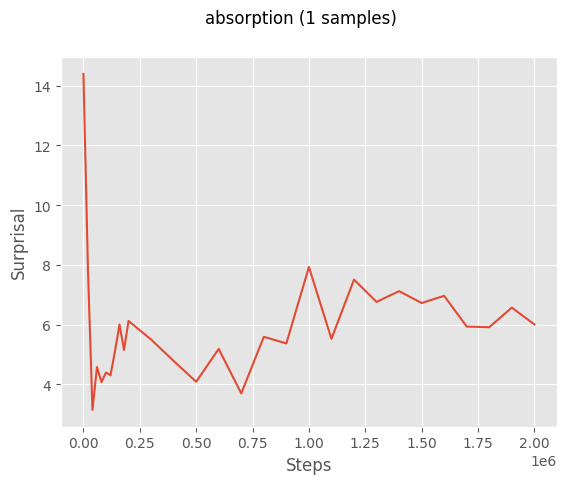

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


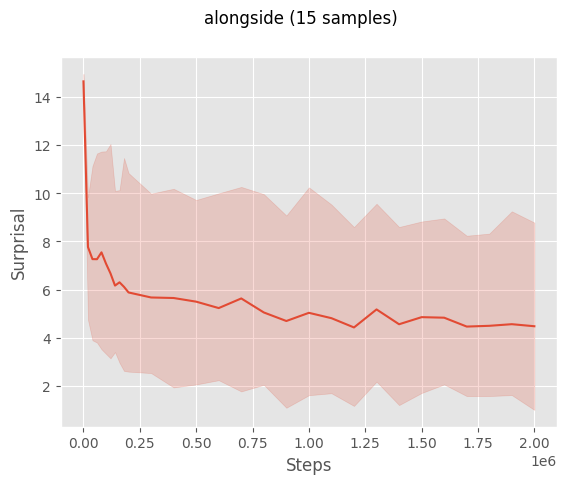

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


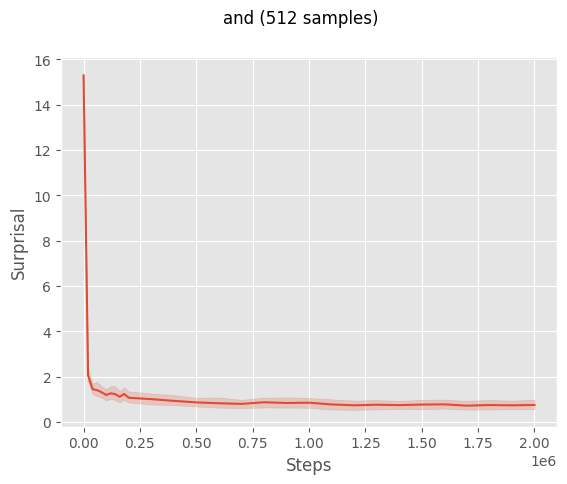

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


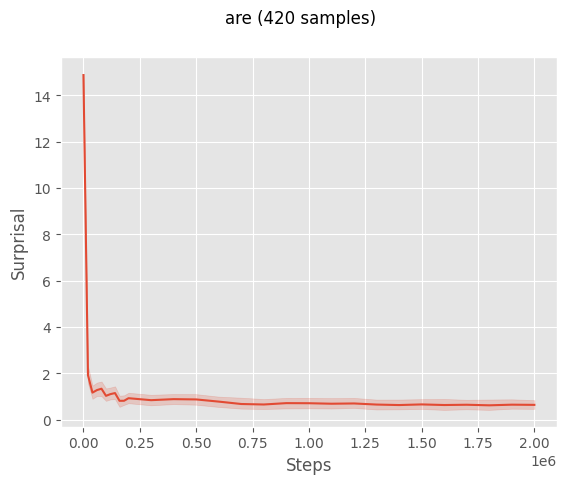

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


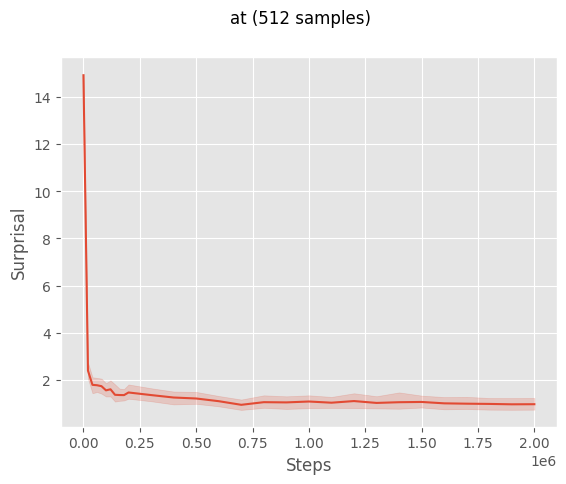

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


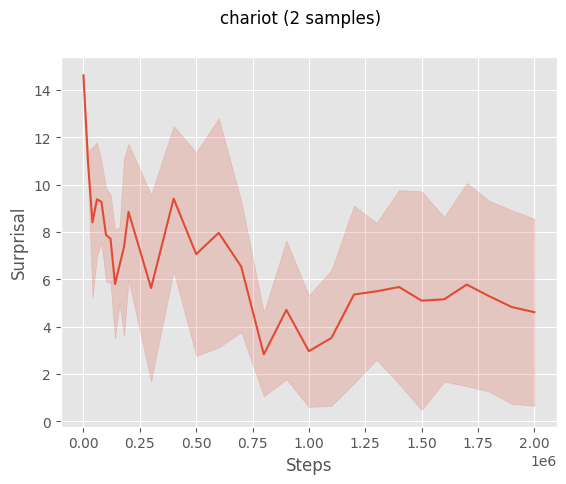

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


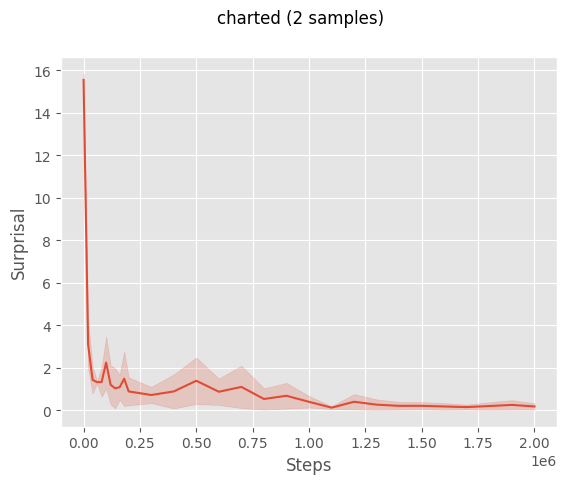

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


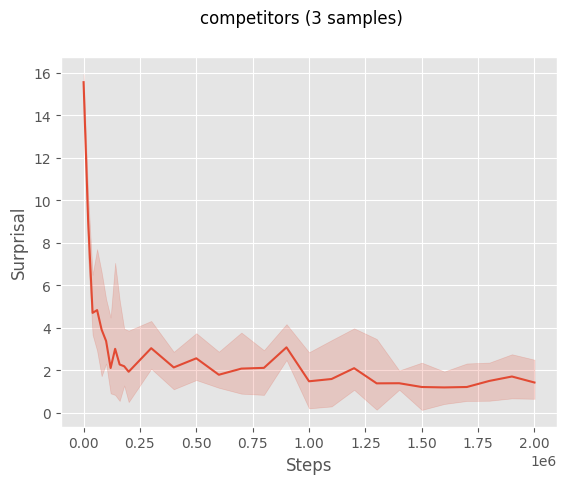

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


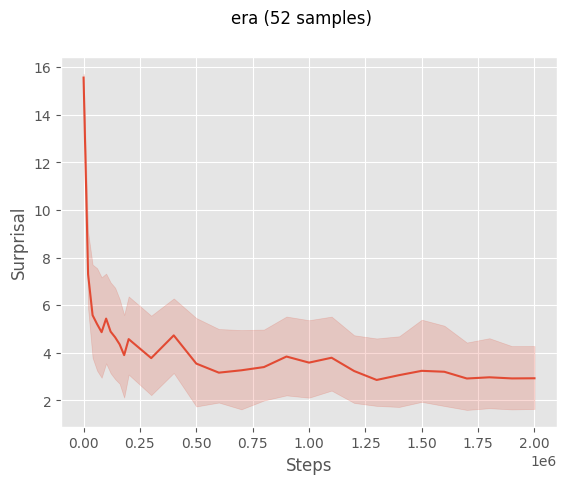

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


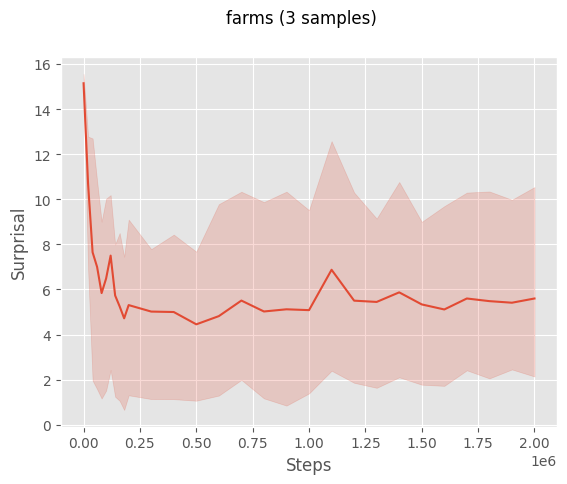

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


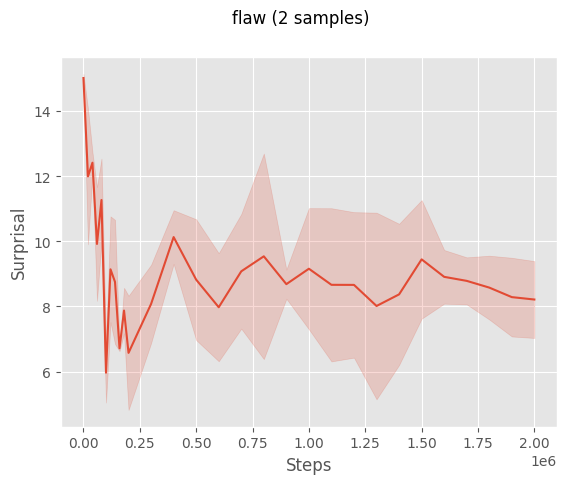

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


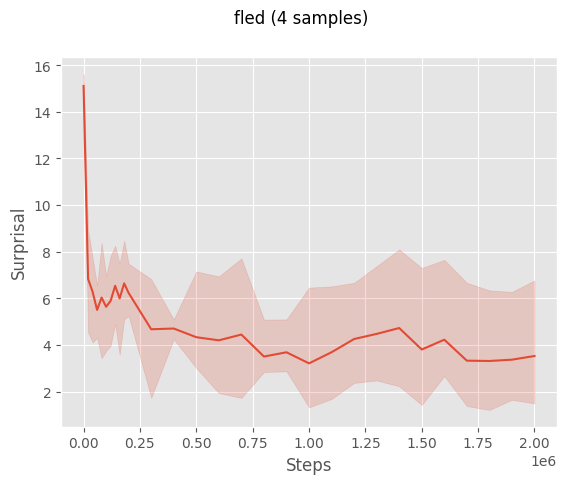

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


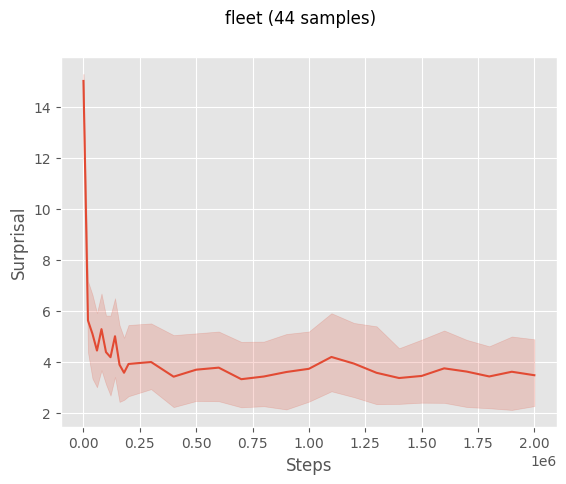

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


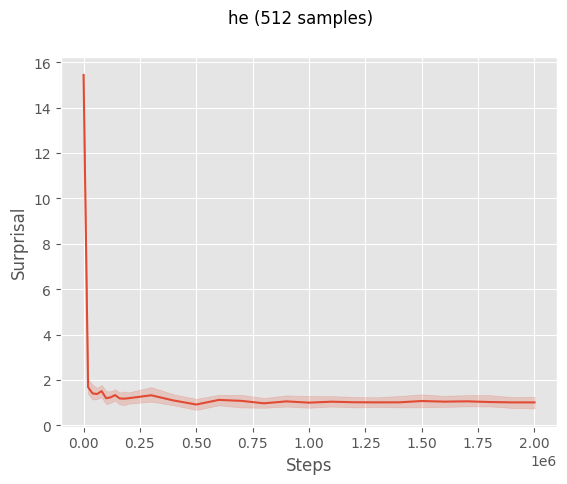

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


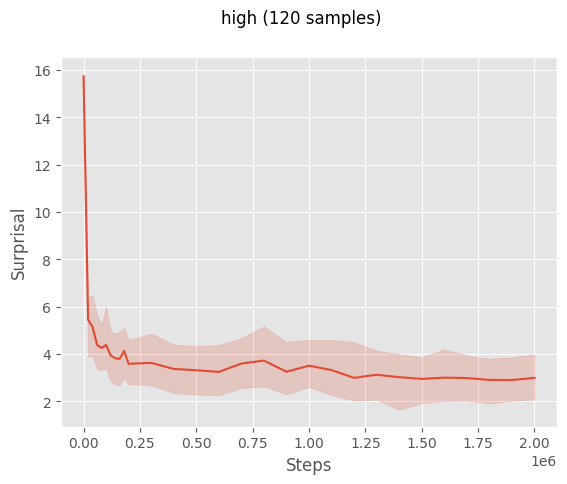

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


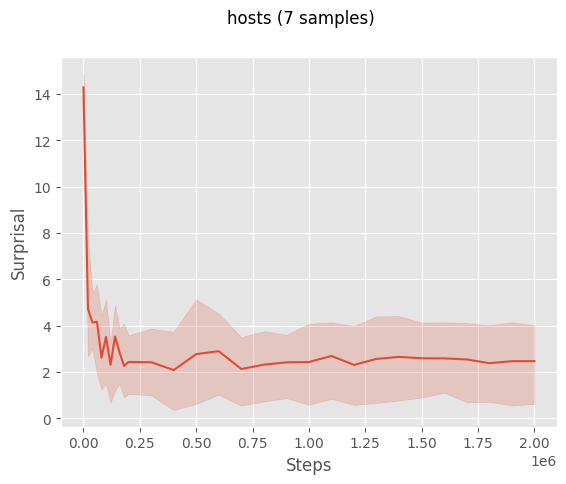

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


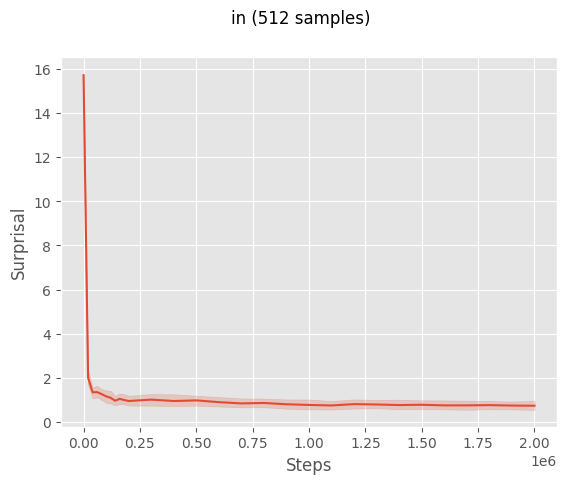

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


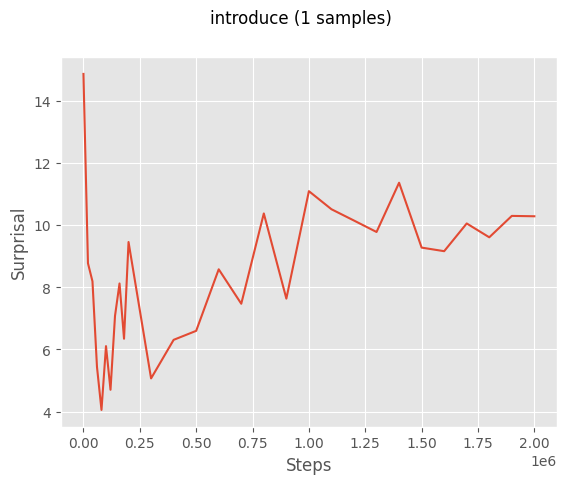

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


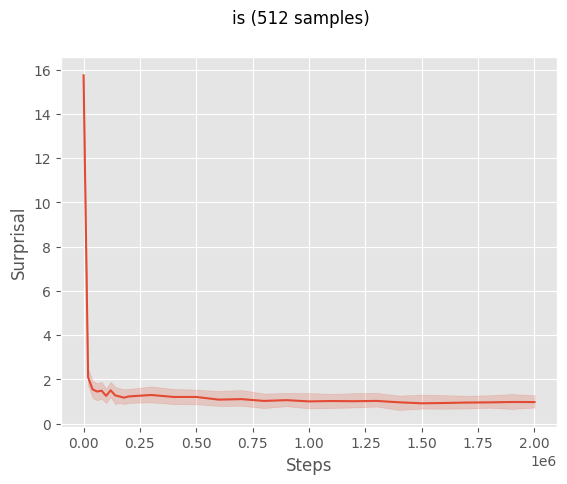

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


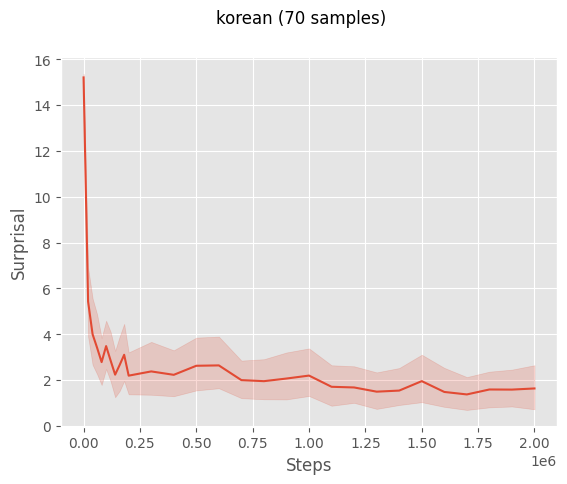

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


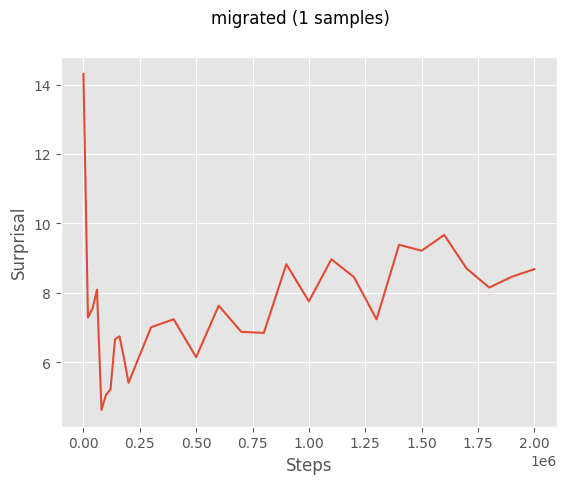

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


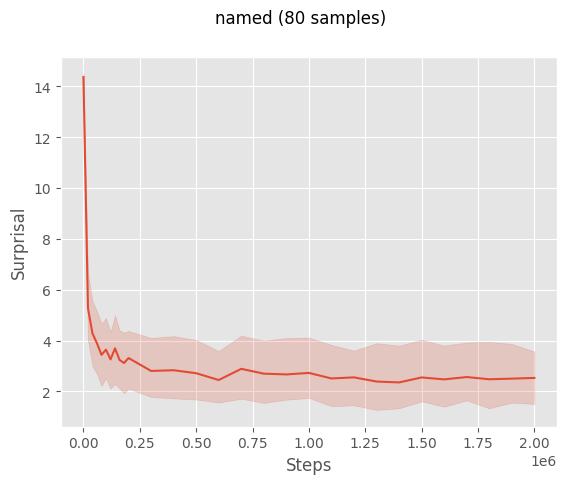

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


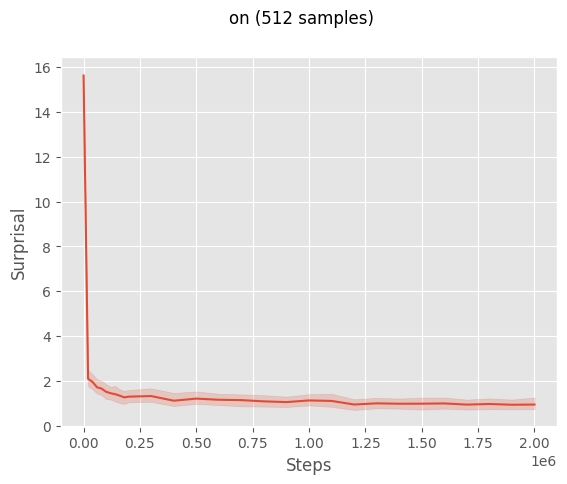

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


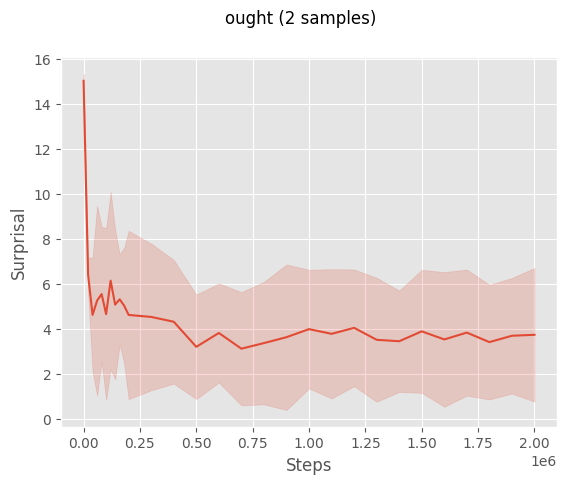

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


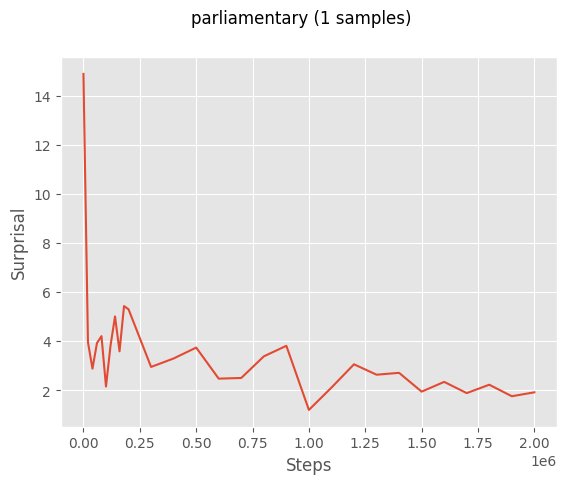

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


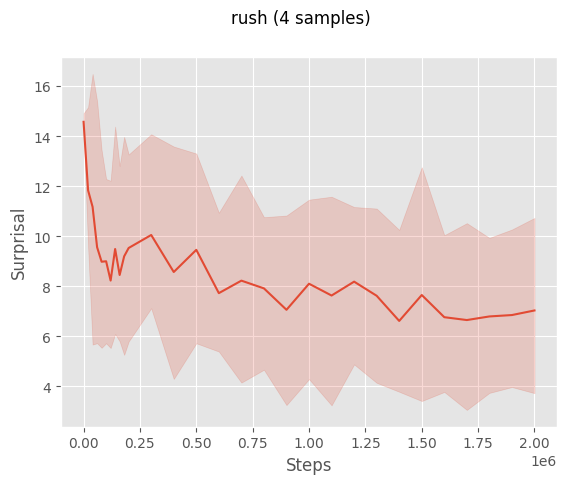

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


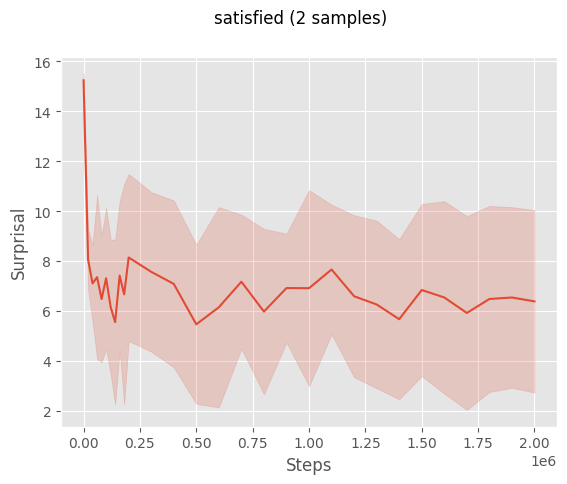

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


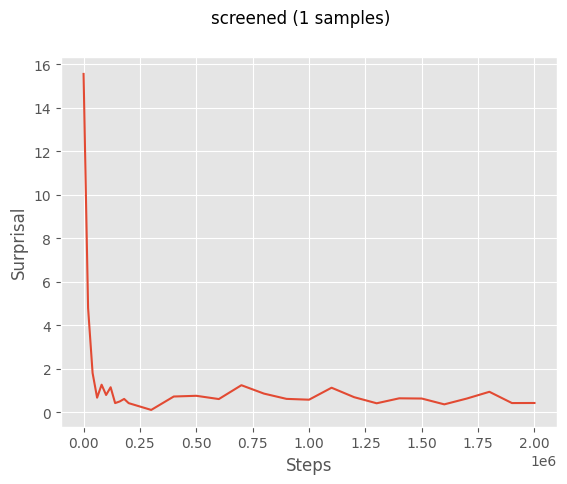

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


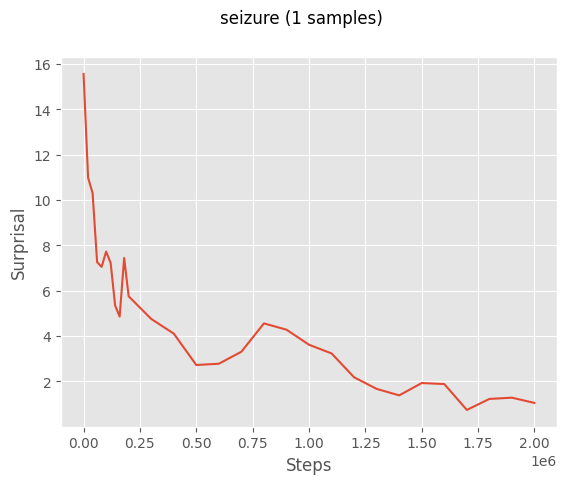

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


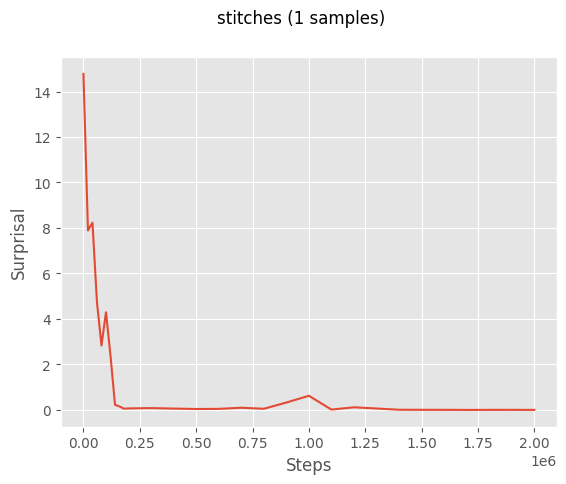

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


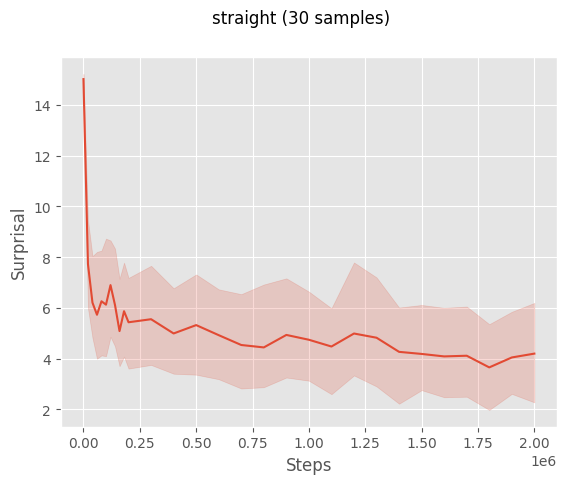

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


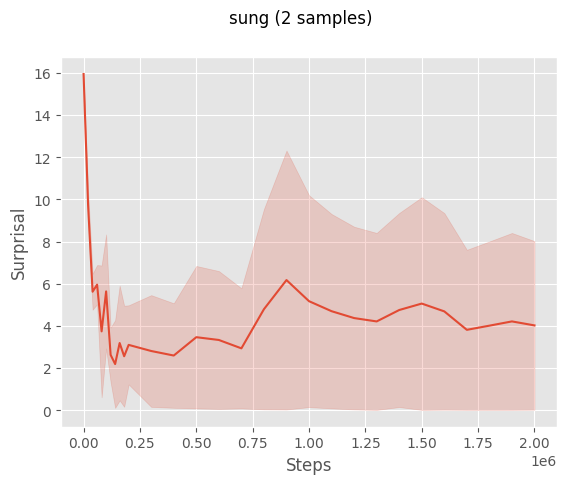

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


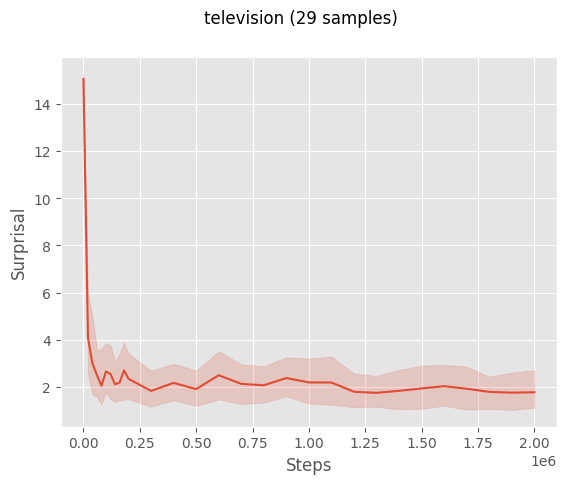

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


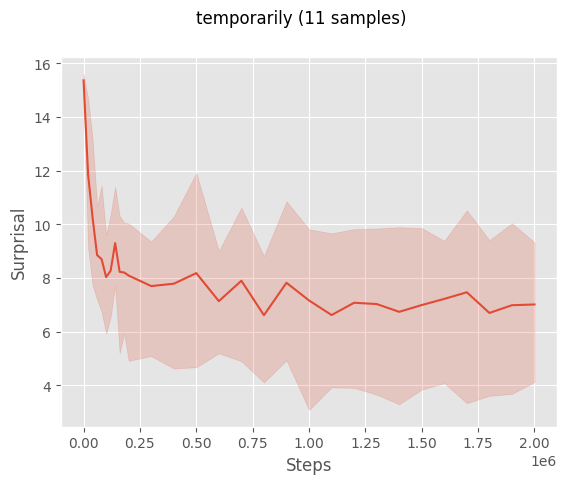

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


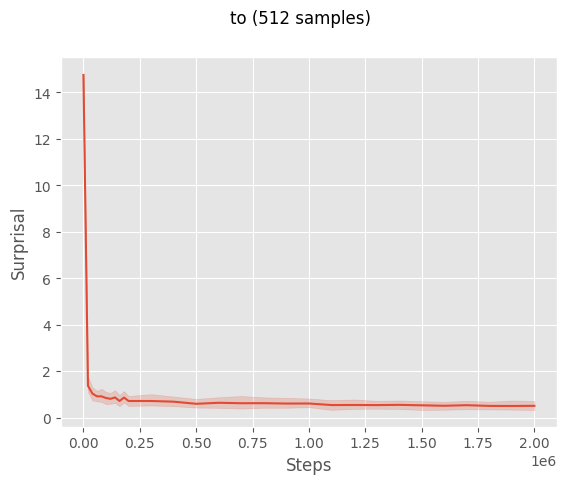

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


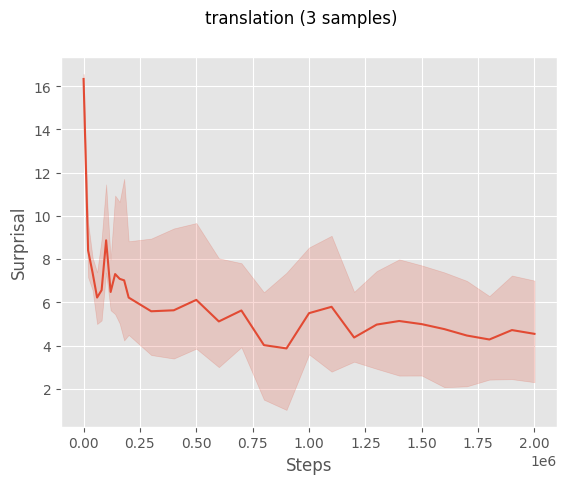

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


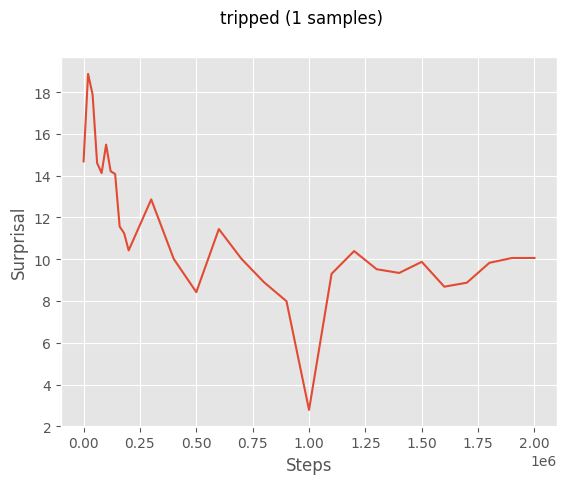

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


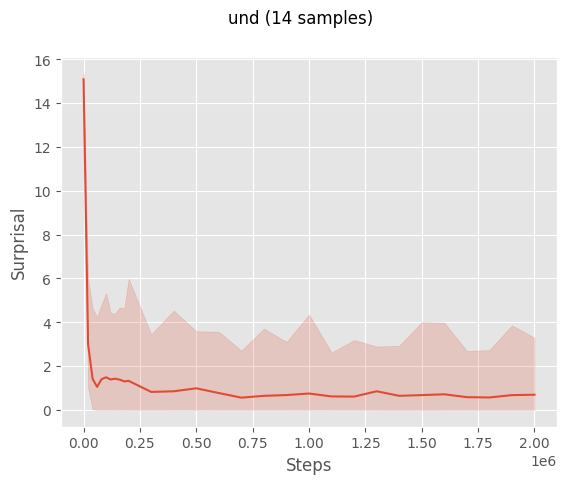

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


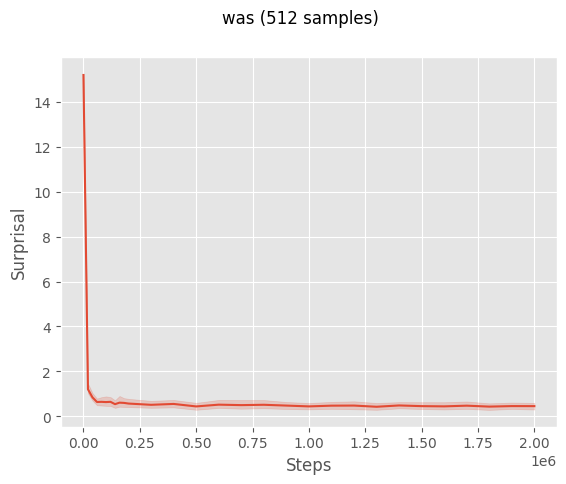

/tmp/ipykernel_578870/3640781317.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: calculate_correlations(x, column_pairs))


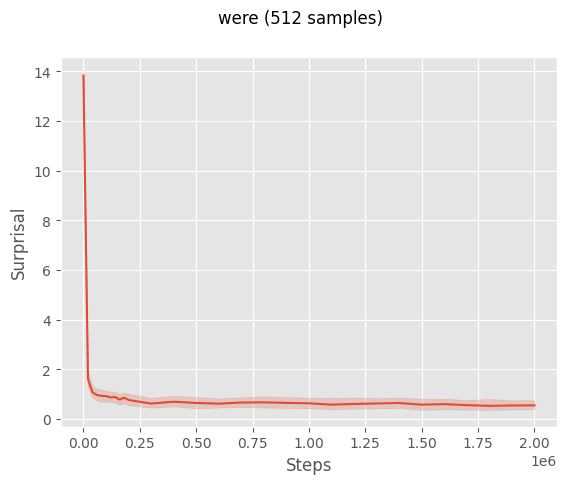

In [63]:
for token in sample40_indiv_surprisals.Token.unique():
    token_data = sample40_indiv_surprisals[sample40_indiv_surprisals.Token == token].reset_index(drop=True)
    column_pairs = [('Surprisal', 'MeanSurprisal'), ('Surprisal', 'NegSurprisal'), ('NegSurprisal', 'MeanNegSurprisal')]
    token_correlations = (token_data[token_data['Steps'] != 0]
                            .groupby('Token')
                            .apply(lambda x: calculate_correlations(x, column_pairs))
                            .reset_index())
    token_count = token_data.groupby('Steps')['Token'].count()[0]
    plot = sns.lineplot(data=token_data, x='Steps', y='Surprisal', errorbar=('ci', 100))
    plot.figure.suptitle(f"{token} ({token_count} samples)")
    plt.show()

### Computing Pearson Correlation

In [ ]:
def pearson_correlation(group):
    if len(group) < 2:
        return None
    corr, _ = pearsonr(group['MeanSurprisal'], group['MeanNegSurprisal'])
    return corr

In [ ]:
wikitext_surprisals = '../results/lexique_results/shuffled_bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [29]:
# correlations = surprisals.groupby('Token').apply(pearson_correlation).dropna()    # including the first step
correlations = surprisals[surprisals['Steps'] != 0].groupby('Token').apply(pearson_correlation).dropna()    # excluding the first step
correlations = pd.DataFrame(correlations, columns=['Correlation']).reset_index()
correlations

/tmp/ipykernel_1869955/2757183774.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = surprisals[surprisals['Steps'] != 0].groupby('Token').apply(pearson_correlation).dropna()    # excluding the first step


,Token,Correlation
0,a,-0.612520
1,aa,-0.737084
2,abandon,-0.632056
3,abandoned,-0.803427
4,abandoning,-0.695387
...,...,...
9073,zone,-0.844724
9074,zones,-0.752386
9075,zoo,0.315776
9076,zoom,-0.765397


In [30]:
# source: Cohen, J. (1988). Statistical power analysis for the behavioral sciences (2nd ed.). Hillsdale, NJ: Lawrence Erlbaum Associates: 
# bins = [-1, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1]

# what looks good :P : 
# bins = [-1, -0.7, -0.3, 0.3, 0.7, 1]
# labels = ['Strong Negative', 'Moderate Negative', 'Weak or No Correlation', 'Moderate Positive', 'Strong Positive']

bins = [-1, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 1] # personal adaptation of Cohen, J. (1988)
labels = ['Strong Negative', 'Moderate Negative', 'Weak Negative', 'No Correlation', 'Weak Positive', 'Moderate Positive', 'Strong Positive']

correlations['Correlation Strength'] = pd.cut(correlations['Correlation'], bins=bins, labels=labels)
correlations

,Token,Correlation,Correlation Strength
0,a,-0.612520,Strong Negative
1,aa,-0.737084,Strong Negative
2,abandon,-0.632056,Strong Negative
3,abandoned,-0.803427,Strong Negative
4,abandoning,-0.695387,Strong Negative
...,...,...,...
9073,zone,-0.844724,Strong Negative
9074,zones,-0.752386,Strong Negative
9075,zoo,0.315776,Moderate Positive
9076,zoom,-0.765397,Strong Negative


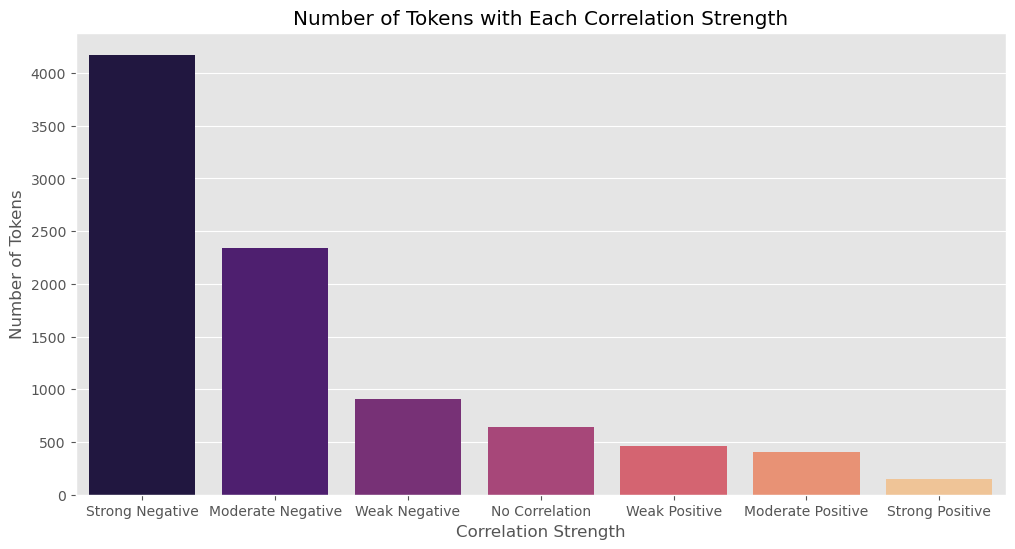

In [210]:
import seaborn as sns

strength_counts = correlations['Correlation Strength'].value_counts().sort_index()

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.barplot(x=strength_counts.index, y=strength_counts.values, hue=strength_counts.index, palette='magma')

plt.ylabel('Number of Tokens')
plt.title('Number of Tokens with Each Correlation Strength')
plt.show()

<Figure size 1200x600 with 0 Axes>

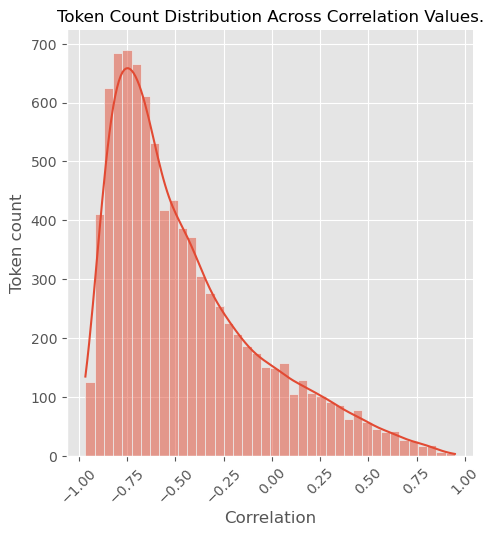

In [217]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.displot(data=correlations, x='Correlation', kde=True)

plt.title('Token Count Distribution Across Correlation Values.', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Token count')

plt.show()

#### Average frequency in each category

In [32]:
wordbank = pd.read_csv('../data/wikitext/wikitext_wordbank.tsv', sep='\t')

correlations['Token Counts'] = wordbank[wordbank.token.isin(correlations.Token.tolist())].reset_index()['count']
correlations

,Token,Correlation,Correlation Strength,Token Counts
0,a,-0.612520,Strong Negative,4030
1,aa,-0.737084,Strong Negative,16
2,abandon,-0.632056,Strong Negative,1
3,abandoned,-0.803427,Strong Negative,26
4,abandoning,-0.695387,Strong Negative,1
...,...,...,...,...
9073,zone,-0.844724,Strong Negative,21
9074,zones,-0.752386,Strong Negative,6
9075,zoo,0.315776,Moderate Positive,2
9076,zoom,-0.765397,Strong Negative,1


In [119]:
# Average token frequency in each category

correlations.groupby('Correlation Strength').agg(Average_Token_Frequency=('Token Counts', 'mean')).reset_index()

/tmp/ipykernel_1869955/3145115596.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlations.groupby('Correlation Strength').agg(Average_Token_Frequency=('Token Counts', 'mean')).reset_index()


,Correlation Strength,Average_Token_Frequency
0,Strong Negative,28.079061
1,Moderate Negative,8.001711
2,Weak Negative,9.294956
3,No Correlation,6.213166
4,Weak Positive,16.767742
5,Moderate Positive,10.785185
6,Strong Positive,8.821918


In [33]:
# Crosstab

def categorize(count):
    if count >= 512:
        return 'frequent'
    elif count == 1:
        return 'infrequent'
    else:
        return 'in between'

correlations['Frequency'] = correlations['Token Counts'].apply(categorize)

pd.crosstab(correlations['Correlation Strength'], correlations['Frequency'])

Frequency,frequent,in between,infrequent
Correlation Strength,,,
Strong Negative,20,3299,855
Moderate Negative,1,1631,706
Weak Negative,1,563,348
No Correlation,0,407,231
Weak Positive,2,254,209
Moderate Positive,1,249,155
Strong Positive,0,92,54


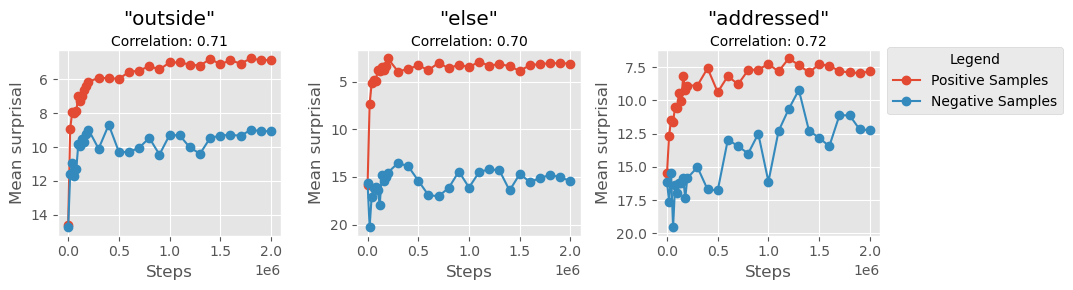

,Token,Correlation,Correlation Strength,Token Counts,Frequency
131,addressed,0.716579,Strong Positive,7,in between
2732,else,0.695632,Strong Positive,9,in between
5573,outside,0.711377,Strong Positive,43,in between


In [38]:
tokens_to_inspect = correlations[(correlations['Correlation Strength'] == 'Strong Positive') & (correlations['Frequency'] == 'in between')]
sample = tokens_to_inspect.Token.sample(3)
corrs = plot_surprisals(sample, surprisals, neg_samples=True, first_step=False)
correlations[correlations['Token'].isin(sample)]

**Observation:**

The results are very different when including and excluding the first step in the correlation calculation.
Many of the words show a strong negative correlation in the first step but positively correlate in subsequent steps and vice versa. 
In order to view the general trend, I decided to exclude the first step from the calculations. 

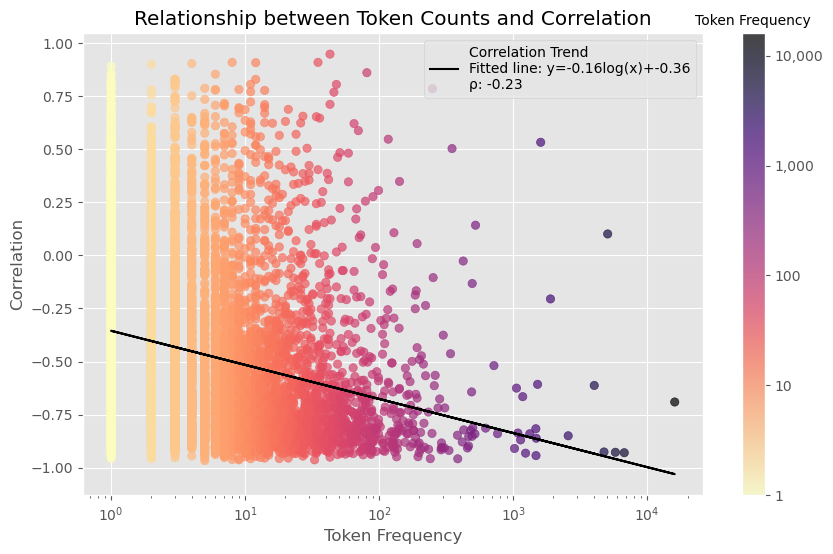

In [221]:
# Plotting the relationship between token counts and correlation strength

from scipy.stats import linregress

x = correlations['Token Counts']
y = correlations['Correlation']

slope, intercept, r, p, stderr = linregress(np.log10(x), y)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=np.log10(x), cmap='magma_r', alpha=0.7)

plt.plot(x, slope * np.log10(x) + intercept, color='black', 
         label=f'Correlation Trend\nFitted line: y={slope:.2f}log(x)+{intercept:.2f}\nρ: {r:.2f}')
plt.legend()

plt.xlabel('Token Frequency')
plt.ylabel('Correlation')
plt.title('Relationship between Token Counts and Correlation')
plt.xscale('log')

cbar = plt.colorbar(scatter)
cbar.ax.set_title('Token Frequency', fontsize=10, loc='center')

log_ticks = np.log10([1, 10, 100, 1000, 10000])
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f"{int(10**i):,}" for i in log_ticks])

plt.grid(True)
plt.show()

**Observation:**

There is a weak negative relationship ($ρ = -0.23$) between token frequency and surprisal correlation

In [182]:
positive_corr = correlations[correlations['Correlation Strength'].isin(['Weak Positive', 'Moderate Positive', 'Strong Positive'])].reset_index(drop=True)

In [190]:
# Number of positive vs. negative trend in words with positive correlation

def calculate_trend(group):
    slope, _, _, _, _ = linregress(group['Steps'], group['MeanSurprisal'])
    return 'decreasing' if slope < 0 else 'increasing'

positive_corr['Surprisal Trend'] = surprisals[(surprisals.Token.isin(positive_corr.Token)) & (surprisals.Steps != 0)]\
    .groupby('Token')[['Steps', 'MeanSurprisal']]\
        .apply(lambda group: calculate_trend(group))\
            .reset_index(level=0, drop=True)

positive_corr['Surprisal Trend'].value_counts()


Surprisal Trend
decreasing    668
increasing    348
Name: count, dtype: int64

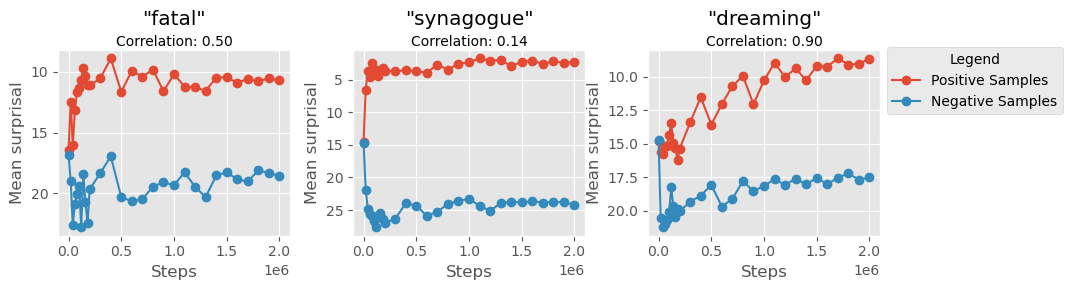

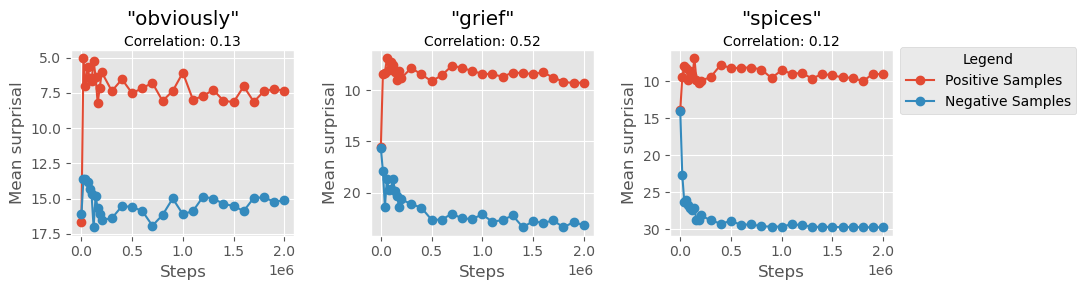

{'obviously': 0.12591590356614876,
 'grief': 0.521238093032871,
 'spices': 0.11995290384100149}

In [192]:
dec_trend_samples = positive_corr[positive_corr['Surprisal Trend'] == 'decreasing'].Token.sample(3)
inc_trend_samples = positive_corr[positive_corr['Surprisal Trend'] == 'increasing'].Token.sample(3)
plot_surprisals(dec_trend_samples, surprisals, neg_samples=True, first_step=False)
plot_surprisals(inc_trend_samples, surprisals, neg_samples=True, first_step=False)

### Top 5 largest and smallest absolute diffs

In [27]:
largest_abs_diffs = merged_df.loc[merged_df['MeanSurprisalDiff'].abs().nlargest(5).index]
largest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
171333,pinyin,20000,0,0.413391,NaN,1.000000,1,-16.335337,0.000000,[NOUN]
37527,certified,20000,0,0.103706,0.213102,1.000000,9,-15.958807,-0.034161,[VERB]
205263,s,20000,0,0.156458,0.832464,0.980469,512,-15.645989,0.436431,[PART]
258449,wasn,20000,0,0.035518,0.026123,1.000000,2,-15.582191,0.016575,"[VERB, NOUN]"
128761,isn,20000,0,0.481655,0.562930,0.666667,3,-15.271394,0.540604,[X]


In [28]:
smallest_abs_diffs = merged_df[merged_df['Steps'] != 0].sort_values(by='MeanSurprisalDiff', key=abs).head(5)
smallest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
203415,romantic,180000,12,6.466520,3.984921,0.222222,9,0.000001,0.162208,[ADJ]
228561,struggle,400000,0,0.741873,NaN,1.000000,1,0.000002,0.000000,[NOUN]
109438,grown,1300000,1,4.066748,3.340114,0.400000,5,0.000002,-0.430809,[VERB]
26819,blanche,1500000,0,0.000110,NaN,1.000000,1,0.000006,0.000000,[NOUN]
110112,gunner,2000000,0,0.001142,NaN,1.000000,1,-0.000007,0.000000,[NOUN]


In [29]:
largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff')).reset_index(drop=True)
largest_diffs[largest_diffs['Steps'] != 0]

/tmp/ipykernel_605400/1962239088.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff')).reset_index(drop=True)


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
5,meadows,20000,28033,25.995031,NaN,0.0,1,12.087551,0.000000,[VERB]
6,regulated,20000,18690,24.933050,NaN,0.0,1,11.021982,0.000000,[VERB]
7,eyebrows,20000,23724,26.026793,NaN,0.0,1,10.978278,0.000000,[NOUN]
8,dwarfs,20000,12753,25.427557,NaN,0.0,1,10.645936,0.000000,[VERB]
9,runaway,20000,10738,25.716511,NaN,0.0,1,9.943949,0.000000,[NOUN]
...,...,...,...,...,...,...,...,...,...,...
140,employs,2000000,682,14.378883,NaN,0.0,1,2.081568,0.000000,[VERB]
141,linebacker,2000000,23,8.991562,NaN,0.0,1,1.918733,0.000000,[NOUN]
142,awaited,2000000,12,7.583819,2.600420,0.0,2,1.430468,2.151388,[VERB]
143,turbulent,2000000,1912,17.191397,0.040059,0.0,2,1.419880,-0.059886,[NOUN]


In [30]:
smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff')).reset_index(drop=True)
smallest_diffs[smallest_diffs['Steps'] != 0]

/tmp/ipykernel_605400/3927067076.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff')).reset_index(drop=True)


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
5,pinyin,20000,0,0.413391,NaN,1.000000,1,-16.335337,0.000000,[NOUN]
6,certified,20000,0,0.103706,0.213102,1.000000,9,-15.958807,-0.034161,[VERB]
7,s,20000,0,0.156458,0.832464,0.980469,512,-15.645989,0.436431,[PART]
8,wasn,20000,0,0.035518,0.026123,1.000000,2,-15.582191,0.016575,"[VERB, NOUN]"
9,isn,20000,0,0.481655,0.562930,0.666667,3,-15.271394,0.540604,[X]
...,...,...,...,...,...,...,...,...,...,...
140,makers,2000000,11,7.317133,NaN,0.000000,1,-1.767333,0.000000,[NOUN]
141,progressing,2000000,1,4.288303,NaN,0.000000,1,-1.260956,0.000000,[VERB]
142,neighbourhoods,2000000,454,12.842174,NaN,0.000000,1,-1.254994,0.000000,[NOUN]
143,detecting,2000000,391,13.944378,NaN,0.000000,1,-1.216012,0.000000,[VERB]


In [31]:
largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])
largest_abs_diffs[largest_abs_diffs['Steps'] != 0]

/tmp/ipykernel_605400/2835847893.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])


,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,171333,pinyin,20000,0,0.413391,NaN,1.000000,1,-16.335337,0.000000,[NOUN]
40000,148627,misses,40000,0,2.977732,2.631396,0.666667,3,-12.677530,0.904474,[NOUN]
60000,78071,eagerly,60000,0,1.739209,NaN,1.000000,1,-10.005972,0.000000,[ADV]
80000,260714,whitehead,80000,699,12.934813,NaN,0.000000,1,8.538087,0.000000,"[ADJ, PROPN]"
100000,154430,neglect,100000,175,11.273901,NaN,0.000000,1,-8.549437,0.000000,[NOUN]
120000,205239,ry,120000,0,1.342942,NaN,1.000000,1,-13.901313,0.000000,[ADP]
140000,205240,ry,140000,423,12.471712,NaN,0.000000,1,11.128770,0.000000,[ADP]
160000,69492,dietary,160000,149,11.057082,NaN,0.000000,1,7.800472,0.000000,[ADJ]
180000,18250,atrocities,180000,262,12.997885,NaN,0.000000,1,8.758473,0.000000,[NOUN]


In [32]:
smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])
smallest_abs_diffs[smallest_abs_diffs['Steps'] != 0]

/tmp/ipykernel_605400/584872678.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])


,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,227680,strengths,20000,602,14.315987,3.633869,0.000000,4,-0.003129,3.351110,[NOUN]
40000,209556,seductive,40000,263,12.590736,0.315317,0.000000,2,-0.000038,-4.173960,[ADJ]
60000,19955,automated,60000,191,11.071678,NaN,0.000000,1,-0.000029,0.000000,[VERB]
80000,183632,proud,80000,0,0.050457,NaN,1.000000,1,0.000034,0.000000,[ADJ]
100000,40692,cities,100000,1,3.060441,3.097222,0.461538,13,-0.000607,-0.064615,[NOUN]
120000,205268,s,120000,0,0.082411,0.514055,0.986328,512,-0.000170,0.051654,[PART]
140000,152025,municipal,140000,25,8.095144,2.473627,0.000000,4,-0.000068,0.412933,[ADJ]
160000,155071,neutron,160000,6,6.023601,NaN,0.000000,1,-0.000062,0.000000,[NOUN]
180000,203415,romantic,180000,12,6.466520,3.984921,0.222222,9,0.000001,0.162208,[ADJ]
